In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# Precinct Shapefile
---
## VEST's Documentation File


Election results from the Tennessee Secretary of State (https://sos.tn.gov/elections/results#2020). Precinct shapefile primarily from the Tennessee Comptroller of the Treasury (https://apps.cot.tn.gov/DPAMaps/Redistrict/Counties). Hamilton County replaced with a shapefile from the county GIS department.

Davidson reported absentee ballots countywide. These were distributed by candidate to precincts based on their share of the precinct-level reported vote. 

The following modifications were made to the shapefile to reflect precinct changes prior to the 2020 general election.

Coffee: Split 13-2/13-4
Hamblen: Merge 10-1/10-2
Hardin: Merge 1-1/1-2, 2-1/2-2, 3-1/3-2, 4-1/4-2
Henderson: Merge Christian Chapel/Darden
Maury: Split Northfield/Spring Hill
McNairy: Merge Cypress/Ramer
Polk: Merge Cooper Basin/Ducktown, Parksville/Shiloh
Sumner: Split Howard ES/Station Camp HS

* G20PRERTRU - Donald J. Trump (Republican Party)
* G20PREDBID - Joseph R. Biden (Democratic Party)
* G20PRELJOR - Jo Jorgensen (Libertarian Party)
* G20PREGHAW - Howie Hawkins (Green Party)
* G20PREIWES - Kanye West (Independent)
* G20PREIBLA - Don Blankenship (Independent)
* G20PREIKEN - Alyson Kennedy (Independent)
* G20PREILAR - Gloria La Riva (Independent)
* G20PREIFUE - Roque "Rocky" De La Fuente (Independent)


* G20USSRHAG - Bill Hagerty (Republican Party)
* G20USSDBRA - Marquita Bradshaw (Democratic Party)
* G20USSIHOO - Steven J. Hooper (Independent)
* G20USSISTA - Eric William Stansberry (Independent)
* G20USSIMCL - Elizabeth McLeod (Independent)
* G20USSIJAM - Aaron James (Independent)
* G20USSIHIL - G. Dean Hill (Independent)
* G20USSIGRU - Jeffrey Alan Grunau (Independent)
* G20USSIHEN - Ronnie Henley (Independent)
* G20USSIFAP - Yomi "Fapas" Faparusi Sr. (Independent)

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/tn_2020/tn_2020.shp")

In [3]:
vest_shp.shape

(1962, 22)

In [4]:
vest_shp.head(1)

,COUNTY,NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,G20PREIWES,G20PREIBLA,G20PREIKEN,G20PREILAR,...,G20USSDBRA,G20USSIHOO,G20USSISTA,G20USSIMCL,G20USSIJAM,G20USSIHIL,G20USSIGRU,G20USSIHEN,G20USSIFAP,geometry
0,16,8,467,93,5,0,1,0,0,0,...,76,1,1,2,0,0,1,2,1,"POLYGON Z ((-89.05690 35.81323 0.00000, -89.05..."


<AxesSubplot:>

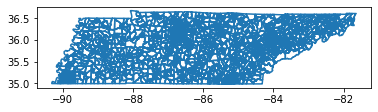

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['COUNTY', 'NAME', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGHAW', 'G20PREIWES', 'G20PREIBLA', 'G20PREIKEN', 'G20PREILAR',
       'G20PREIFUE', 'G20USSRHAG', 'G20USSDBRA', 'G20USSIHOO', 'G20USSISTA',
       'G20USSIMCL', 'G20USSIJAM', 'G20USSIHIL', 'G20USSIGRU', 'G20USSIHEN',
       'G20USSIFAP', 'geometry'],
      dtype='object')

## Load the SOS Election Results File

The SOS directed to this link for election results for the 2016 general: https://sos.tn.gov/products/elections/election-results

In [7]:
# Import file
tn_20 = pd.read_excel("./raw-from-source/2020_TN_Election_Results.xlsx")

In [8]:
tn_20.head()

,COUNTY,PRCTSEQ,PRECINCT,BALSEQID,JURISID,CANDGROUP,OFFICENAME,ELECTDATE,COL1HDG,RNAME1,...,PARTY8,PVTALLY8,COL9HDG,RNAME9,PARTY9,PVTALLY9,COL10HDG,RNAME10,PARTY10,PVTALLY10
0,Anderson,1,Andersonville,3,0,1,United States President,2020-11-03,1,Donald J. Trump,...,Independent,0.0,9.0,Kanye West,Independent,0.0,10.0,Write-In - R19 Boddie,NaN,0.0
1,Anderson,1,Andersonville,3,0,2,United States President,2020-11-03,11,Write-In - Brian Carroll,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Anderson,1,Andersonville,7,0,1,United States Senate,2020-11-03,1,Bill Hagerty,...,Independent,2.0,9.0,Elizabeth McLeod,Independent,7.0,10.0,Kacey Morgan,Independent,2.0
3,Anderson,1,Andersonville,7,0,2,United States Senate,2020-11-03,11,Eric William Stansberry,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Anderson,1,Andersonville,11,3,0,United States House of Representatives District 3,2020-11-03,1,Chuck Fleischmann,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean Up the Election Results
Tennessee had 5 different presidential write-in candidates and 2 different senate write-in candidates where the votes were counted seperately according to each candidate. All write-in votes have been been combined here.

### Presidential

In [9]:
# Filter down rows containing presidential election results
pre_20 = tn_20[tn_20['OFFICENAME'] == 'United States President']

# Filter down columns
cols = ['COUNTY','PRECINCT','COL1HDG','PVTALLY1','PVTALLY2','PVTALLY3','PVTALLY4','PVTALLY5','PVTALLY6','PVTALLY7','PVTALLY8','PVTALLY9','PVTALLY10']
pre_20 = pre_20.reindex(columns = cols)

# Create dataframe consisting of first row of presidential election data
pre_20_1 = pre_20[pre_20['COL1HDG'] != 11]
pre_20_1.reset_index(drop=True, inplace = True)

# Create dataframe consisting of second row of presidential election data
pre_20_2 = pre_20[pre_20['COL1HDG'] == 11]
pre_20_2 = pre_20_2.drop(['COUNTY','PRECINCT','COL1HDG','PVTALLY5','PVTALLY6','PVTALLY7','PVTALLY8','PVTALLY9','PVTALLY10'], axis = 1)

# Rename the columns to avoid duplicate column names
pre_20_2.columns = ['PVTALLY11','PVTALLY12','PVTALLY13','PVTALLY14',]
pre_20_2.reset_index(drop=True, inplace = True)

# Concatenate the second dataframe to the first dataframe
pre_20 = pd.concat([pre_20_1,pre_20_2], axis = 1, ignore_index = False)

# Add all the write-in votes
pre_20['PVTALLY10'] = pre_20.PVTALLY10 + pre_20.PVTALLY11 + pre_20.PVTALLY12 + pre_20.PVTALLY13+ pre_20.PVTALLY14

# Drop all the write-in columns except for the column with sum of all the write-in votes
pre_20 = pre_20.drop(['COL1HDG','PVTALLY11','PVTALLY12','PVTALLY13','PVTALLY14'], axis = 1)
pre_20

# drop the row with write-in votes 
pre_20 = pre_20.drop(['PVTALLY10'], axis = 1)

# Deal with the index
pre_20.reset_index(drop=True, inplace = True)
pre_20

,COUNTY,PRECINCT,PVTALLY1,PVTALLY2,PVTALLY3,PVTALLY4,PVTALLY5,PVTALLY6,PVTALLY7,PVTALLY8,PVTALLY9
0,Anderson,Andersonville,1554,307.0,1.0,0.0,2.0,13.0,2.0,0.0,0.0
1,Anderson,Briceville,333,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,Bull Run,1692,567.0,3.0,0.0,3.0,29.0,1.0,1.0,1.0
3,Anderson,Clinton,1548,647.0,6.0,0.0,2.0,18.0,0.0,1.0,5.0
4,Anderson,Clinton High,962,366.0,4.0,1.0,1.0,7.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1960,Wilson,22-1,1923,877.0,6.0,0.0,1.0,39.0,4.0,1.0,15.0
1961,Wilson,23-1,2868,1012.0,8.0,2.0,0.0,39.0,2.0,6.0,14.0
1962,Wilson,24-1,1374,723.0,7.0,0.0,2.0,21.0,3.0,7.0,19.0
1963,Wilson,25-1,1849,931.0,4.0,2.0,4.0,34.0,7.0,6.0,24.0


In [10]:
# Rename the columns to match VEST
pre_20.columns = ['COUNTY','PRECINCT','G20PRERTRU', 'G20PREDBID', 'G20PREIBLA', 'G20PREIFUE','G20PREGHAW','G20PRELJOR',
       'G20PREIKEN', 'G20PREILAR', 'G20PREIWES']

# Reorder the columns to match VEST
pre_20 = pre_20[['COUNTY','PRECINCT','G20PRERTRU', 'G20PREDBID', 'G20PRELJOR','G20PREGHAW',
       'G20PREIWES', 'G20PREIBLA', 'G20PREIKEN', 'G20PREILAR', 'G20PREIFUE']]

# Fill n/a values with 0
pre_20 = pre_20.fillna(0)

pre_20

,COUNTY,PRECINCT,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,G20PREIWES,G20PREIBLA,G20PREIKEN,G20PREILAR,G20PREIFUE
0,Anderson,Andersonville,1554,307.0,13.0,2.0,0.0,1.0,2.0,0.0,0.0
1,Anderson,Briceville,333,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,Bull Run,1692,567.0,29.0,3.0,1.0,3.0,1.0,1.0,0.0
3,Anderson,Clinton,1548,647.0,18.0,2.0,5.0,6.0,0.0,1.0,0.0
4,Anderson,Clinton High,962,366.0,7.0,1.0,0.0,4.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1960,Wilson,22-1,1923,877.0,39.0,1.0,15.0,6.0,4.0,1.0,0.0
1961,Wilson,23-1,2868,1012.0,39.0,0.0,14.0,8.0,2.0,6.0,2.0
1962,Wilson,24-1,1374,723.0,21.0,2.0,19.0,7.0,3.0,7.0,0.0
1963,Wilson,25-1,1849,931.0,34.0,4.0,24.0,4.0,7.0,6.0,2.0


### Senator

In [11]:
# Filter down rows containing senator election results
sen_20 = tn_20[tn_20['OFFICENAME'] == 'United States Senate']

# Filter down columns
cols = ['COUNTY','PRECINCT','COL1HDG','PVTALLY1','PVTALLY2','PVTALLY3','PVTALLY4','PVTALLY5','PVTALLY6','PVTALLY7','PVTALLY8','PVTALLY9','PVTALLY10']
sen_20 = sen_20.reindex(columns = cols)

# Create dataframe consisting of first row of senator election data
sen_20_1 = sen_20[sen_20['COL1HDG'] != 11]
sen_20_1.reset_index(drop=True, inplace = True)

# Drop Morgan
sen_20_1 = sen_20_1.drop(['PVTALLY10'], axis = 1)

sen_20_1

# Create dataframe consisting of election data for senator candidate Stansberry
sen_20_2 = sen_20[sen_20['COL1HDG'] == 11]
sen_20_2 = sen_20_2[['PVTALLY1']]
sen_20_2 = sen_20_2.rename(columns = {'PVTALLY1':'PVTALLY10'})
sen_20_2.reset_index(drop=True, inplace = True)
sen_20_2

# Concatenate the second dataframe to the first dataframe
sen_20 = pd.concat([sen_20_1,sen_20_2], axis = 1, ignore_index = False)
sen_20 = sen_20.drop(['COL1HDG'],axis=1)

# Deal with the index
sen_20.reset_index(drop=True, inplace = True)
sen_20

,COUNTY,PRECINCT,PVTALLY1,PVTALLY2,PVTALLY3,PVTALLY4,PVTALLY5,PVTALLY6,PVTALLY7,PVTALLY8,PVTALLY9,PVTALLY10
0,Anderson,Andersonville,1529,268.0,2.0,3.0,5.0,2.0,1.0,2.0,7.0,4
1,Anderson,Briceville,317,58.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,1
2,Anderson,Bull Run,1677,526.0,5.0,2.0,4.0,1.0,8.0,5.0,12.0,3
3,Anderson,Clinton,1513,595.0,9.0,2.0,4.0,3.0,3.0,0.0,14.0,3
4,Anderson,Clinton High,943,328.0,2.0,1.0,2.0,1.0,3.0,1.0,6.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1957,Wilson,22-1,1934,796.0,13.0,6.0,6.0,7.0,12.0,6.0,15.0,3
1958,Wilson,23-1,2888,908.0,11.0,6.0,12.0,4.0,11.0,18.0,11.0,6
1959,Wilson,24-1,1355,661.0,2.0,3.0,10.0,2.0,11.0,13.0,21.0,4
1960,Wilson,25-1,1898,841.0,10.0,6.0,15.0,5.0,9.0,17.0,15.0,3


In [12]:
# Rename the columns to match VEST
sen_20.columns = ['COUNTY','PRECINCT','G20USSRHAG', 'G20USSDBRA', 'G20USSIFAP', 'G20USSIGRU','G20USSIHEN','G20USSIHIL',
       'G20USSIHOO', 'G20USSIJAM', 'G20USSIMCL','G20USSISTA']

# Reorder the columns to match VEST
sen_20 = sen_20[['COUNTY','PRECINCT','G20USSRHAG', 'G20USSDBRA', 'G20USSIHOO','G20USSISTA',
       'G20USSIMCL', 'G20USSIJAM', 'G20USSIHIL', 'G20USSIGRU', 'G20USSIHEN','G20USSIFAP']]

# Fill n/a values with 0
sen_20 = sen_20.fillna(0)

sen_20

,COUNTY,PRECINCT,G20USSRHAG,G20USSDBRA,G20USSIHOO,G20USSISTA,G20USSIMCL,G20USSIJAM,G20USSIHIL,G20USSIGRU,G20USSIHEN,G20USSIFAP
0,Anderson,Andersonville,1529,268.0,1.0,4,7.0,2.0,2.0,3.0,5.0,2.0
1,Anderson,Briceville,317,58.0,0.0,1,1.0,2.0,0.0,1.0,2.0,1.0
2,Anderson,Bull Run,1677,526.0,8.0,3,12.0,5.0,1.0,2.0,4.0,5.0
3,Anderson,Clinton,1513,595.0,3.0,3,14.0,0.0,3.0,2.0,4.0,9.0
4,Anderson,Clinton High,943,328.0,3.0,3,6.0,1.0,1.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1957,Wilson,22-1,1934,796.0,12.0,3,15.0,6.0,7.0,6.0,6.0,13.0
1958,Wilson,23-1,2888,908.0,11.0,6,11.0,18.0,4.0,6.0,12.0,11.0
1959,Wilson,24-1,1355,661.0,11.0,4,21.0,13.0,2.0,3.0,10.0,2.0
1960,Wilson,25-1,1898,841.0,9.0,3,15.0,17.0,5.0,6.0,15.0,10.0


### Allocate Votes

In [13]:
data_columns = ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGHAW', 'G20PREIWES', 'G20PREIBLA', 'G20PREIKEN', 'G20PREILAR',
       'G20PREIFUE', 'G20USSRHAG', 'G20USSDBRA',
       'G20USSIHOO', 'G20USSISTA', 'G20USSIMCL', 'G20USSIJAM', 'G20USSIHIL',
       'G20USSIGRU', 'G20USSIHEN', 'G20USSIFAP']
pre_columns = ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGHAW', 'G20PREIWES', 'G20PREIBLA', 'G20PREIKEN', 'G20PREILAR',
       'G20PREIFUE']
sen_columns = ['G20USSRHAG', 'G20USSDBRA', 'G20USSIHOO',
       'G20USSISTA', 'G20USSIMCL', 'G20USSIJAM', 'G20USSIHIL', 'G20USSIGRU',
       'G20USSIHEN', 'G20USSIFAP']

In [14]:
# Create a list containing entries that indicate early voting, write-in, provisional, and paper ballots
to_allocate_list = ['Early voting',
'Early Voting - Write-Ins',
'Provisional - Write-Ins',
'Provisional',
'Absentee',
'Paper Ballots']

In [15]:
pre_to_allocate = pre_20[pre_20["PRECINCT"].isin(to_allocate_list)]
pre_to_add_to = pre_20[~pre_20["PRECINCT"].isin(to_allocate_list)]

sen_to_allocate = sen_20[sen_20["PRECINCT"].isin(to_allocate_list)]
sen_to_add_to = sen_20[~sen_20["PRECINCT"].isin(to_allocate_list)]

In [16]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [17]:
pre_allocated = allocate_absentee(pre_to_add_to,pre_to_allocate,pre_columns,'COUNTY')
pre_allocated.reset_index(drop=True, inplace = True)

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [18]:
pre_allocated

,COUNTY,PRECINCT,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,G20PREIWES,G20PREIBLA,G20PREIKEN,G20PREILAR,G20PREIFUE
0,Anderson,Andersonville,1554.0,307.0,13.0,2.0,0.0,1.0,2.0,0.0,0.0
1,Anderson,Briceville,333.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,Bull Run,1692.0,567.0,29.0,3.0,1.0,3.0,1.0,1.0,0.0
3,Anderson,Clinton,1548.0,647.0,18.0,2.0,5.0,6.0,0.0,1.0,0.0
4,Anderson,Clinton High,962.0,366.0,7.0,1.0,0.0,4.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1956,Wilson,22-1,1923.0,877.0,39.0,1.0,15.0,6.0,4.0,1.0,0.0
1957,Wilson,23-1,2868.0,1012.0,39.0,0.0,14.0,8.0,2.0,6.0,2.0
1958,Wilson,24-1,1374.0,723.0,21.0,2.0,19.0,7.0,3.0,7.0,0.0
1959,Wilson,25-1,1849.0,931.0,34.0,4.0,24.0,4.0,7.0,6.0,2.0


In [19]:
sen_allocated = allocate_absentee(sen_to_add_to,sen_to_allocate,sen_columns,'COUNTY')
sen_allocated.reset_index(drop=True, inplace = True)

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [20]:
sen_allocated

,COUNTY,PRECINCT,G20USSRHAG,G20USSDBRA,G20USSIHOO,G20USSISTA,G20USSIMCL,G20USSIJAM,G20USSIHIL,G20USSIGRU,G20USSIHEN,G20USSIFAP
0,Anderson,Andersonville,1529.0,268.0,1.0,4.0,7.0,2.0,2.0,3.0,5.0,2.0
1,Anderson,Briceville,317.0,58.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,1.0
2,Anderson,Bull Run,1677.0,526.0,8.0,3.0,12.0,5.0,1.0,2.0,4.0,5.0
3,Anderson,Clinton,1513.0,595.0,3.0,3.0,14.0,0.0,3.0,2.0,4.0,9.0
4,Anderson,Clinton High,943.0,328.0,3.0,3.0,6.0,1.0,1.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1956,Wilson,22-1,1934.0,796.0,12.0,3.0,15.0,6.0,7.0,6.0,6.0,13.0
1957,Wilson,23-1,2888.0,908.0,11.0,6.0,11.0,18.0,4.0,6.0,12.0,11.0
1958,Wilson,24-1,1355.0,661.0,11.0,4.0,21.0,13.0,2.0,3.0,10.0,2.0
1959,Wilson,25-1,1898.0,841.0,9.0,3.0,15.0,17.0,5.0,6.0,15.0,10.0


### Create a Dataframe with All Election Results

In [21]:
# Concatenate the second dataframe to the first dataframe
tn_20 = pd.concat([pre_allocated,sen_allocated], axis = 1, ignore_index = False)

tn_20 = tn_20.loc[:,~tn_20.columns.duplicated()]

# Deal with the index
tn_20.reset_index(drop=True, inplace = True)

In [22]:
# # Convert votes recorded as strings to integers
# tn_20[['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
#        'G20PREGHAW', 'G20PREIWES', 'G20PREIBLA', 'G20PREIKEN', 'G20PREILAR',
#        'G20PREIFUE', 'COUNTY', 'PRECINCT', 'G20USSRHAG', 'G20USSDBRA',
#        'G20USSIHOO', 'G20USSISTA', 'G20USSIMCL', 'G20USSIJAM', 'G20USSIHIL',
#        'G20USSIGRU', 'G20USSIHEN', 'G20USSIFAP']].astype(str)

In [23]:
tn_20.columns

Index(['COUNTY', 'PRECINCT', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGHAW', 'G20PREIWES', 'G20PREIBLA', 'G20PREIKEN', 'G20PREILAR',
       'G20PREIFUE', 'G20USSRHAG', 'G20USSDBRA', 'G20USSIHOO', 'G20USSISTA',
       'G20USSIMCL', 'G20USSIJAM', 'G20USSIHIL', 'G20USSIGRU', 'G20USSIHEN',
       'G20USSIFAP'],
      dtype='object')

### Creata a Column in VEST for County Names
Counties 18 and 19 in VEST were recorded as one county in the election results. (Davidson County)
Counties 80,81,82 (Shelby County)

VEST's county numbers were assigned alphabetically.

In [24]:
county_number_change = {'19':'18','81':'80','82':'80'}
vest_shp = vest_shp.replace({'COUNTY': county_number_change})

In [25]:
# Add county names in VEST to assign FIPS
vest_shp['COUNTY_NAME'] = vest_shp['COUNTY']
vest_county_number = vest_shp['COUNTY_NAME'].unique()
vest_county_number = sorted(vest_county_number)
vest_county_number

['00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98']

In [26]:
print((len(vest_shp['COUNTY_NAME'].unique())))

95


In [27]:
# Change DeKalb to Dekalb for ordering
tn_20['COUNTY'].replace(['DeKalb'],'Dekalb')

0       Anderson
1       Anderson
2       Anderson
3       Anderson
4       Anderson
          ...   
1956      Wilson
1957      Wilson
1958      Wilson
1959      Wilson
1960      Wilson
Name: COUNTY, Length: 1961, dtype: object

In [28]:
tn_20['COUNTY']

0       Anderson
1       Anderson
2       Anderson
3       Anderson
4       Anderson
          ...   
1956      Wilson
1957      Wilson
1958      Wilson
1959      Wilson
1960      Wilson
Name: COUNTY, Length: 1961, dtype: object

In [29]:
tn_20.PRECINCT.unique().tolist()

['Andersonville',
 'Briceville',
 'Bull Run',
 'Clinton',
 'Clinton High',
 'Claxton',
 'Clinton Middle',
 'Dutch Valley',
 'Emory Valley',
 'Fairview',
 'Glen Alpine',
 'Glenwood',
 'Hendrix Creek',
 'Highland View',
 'Lake City MS',
 'Marlow',
 'North Clinton',
 'Norris',
 'Norwood',
 'Oak Ridge',
 'Pine Valley',
 'Robertsville',
 'Rosedale',
 'Rocky Top',
 'South Clinton',
 'Woodland',
 'West Hills',
 '1-1 Wartrace',
 '1-2 Bell Buckle',
 '2-3 Fair Haven',
 '3-3 Unionville',
 '4-3 Bedford',
 '5-2 Flat Creek',
 '5-5 Normandy',
 '6-1 East Side',
 '7-1 Deery Eakin',
 '8-1 Thomas',
 '9-2 Southside',
 '1 Holladay',
 '2 Camden Jr High',
 '3 Camden City Hall',
 '4 Camden Elementary',
 '5 Library',
 '6 Big Sandy',
 '1-1 Dill',
 '1-2 Griffith',
 '1-3 Mt. Crest',
 '2-1 Cold Springs',
 '2-2 Luminary',
 '3-1 Brayton',
 '3-2 Rigsby',
 '4-1 Pikeville',
 '5-1 Bellview',
 '5-2 Nine Mile',
 '6-1 Lee Station',
 '6-2 Lusk',
 'Alcoa',
 'Big Springs',
 'Board of Education',
 'Carpenters',
 'Chilhowee Vie

In [30]:
election_county = tn_20['COUNTY'].unique()
election_county = sorted(election_county)

In [31]:
# match the VEST's county numbers to election results' county names
vest_county_name_dict = dict(zip(vest_county_number,election_county))
vest_county_name_dict

{'00': 'Anderson',
 '01': 'Bedford',
 '02': 'Benton',
 '03': 'Bledsoe',
 '04': 'Blount',
 '05': 'Bradley',
 '06': 'Campbell',
 '07': 'Cannon',
 '08': 'Carroll',
 '09': 'Carter',
 '10': 'Cheatham',
 '11': 'Chester',
 '12': 'Claiborne',
 '13': 'Clay',
 '14': 'Cocke',
 '15': 'Coffee',
 '16': 'Crockett',
 '17': 'Cumberland',
 '18': 'Davidson',
 '20': 'Decatur',
 '21': 'Dekalb',
 '22': 'Dickson',
 '23': 'Dyer',
 '24': 'Fayette',
 '25': 'Fentress',
 '26': 'Franklin',
 '27': 'Gibson',
 '28': 'Giles',
 '29': 'Grainger',
 '30': 'Greene',
 '31': 'Grundy',
 '32': 'Hamblen',
 '33': 'Hamilton',
 '35': 'Hancock',
 '36': 'Hardeman',
 '37': 'Hardin',
 '38': 'Hawkins',
 '39': 'Haywood',
 '40': 'Henderson',
 '41': 'Henry',
 '42': 'Hickman',
 '43': 'Houston',
 '44': 'Humphreys',
 '45': 'Jackson',
 '46': 'Jefferson',
 '47': 'Johnson',
 '48': 'Knox',
 '49': 'Lake',
 '50': 'Lauderdale',
 '51': 'Lawrence',
 '52': 'Lewis',
 '53': 'Lincoln',
 '54': 'Loudon',
 '55': 'Macon',
 '56': 'Madison',
 '57': 'Marion',
 

In [32]:
vest_shp['COUNTY_NAME'] = vest_shp['COUNTY_NAME'].map(vest_county_name_dict).fillna(vest_shp['COUNTY_NAME'])
vest_shp

,COUNTY,NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,G20PREIWES,G20PREIBLA,G20PREIKEN,G20PREILAR,...,G20USSIHOO,G20USSISTA,G20USSIMCL,G20USSIJAM,G20USSIHIL,G20USSIGRU,G20USSIHEN,G20USSIFAP,geometry,COUNTY_NAME
0,16,8,467,93,5,0,1,0,0,0,...,1,1,2,0,0,1,2,1,"POLYGON Z ((-89.05690 35.81323 0.00000, -89.05...",Crockett
1,16,6,473,102,2,0,1,1,0,0,...,0,1,0,0,0,0,1,0,"POLYGON Z ((-89.02185 35.85440 0.00000, -89.02...",Crockett
2,17,Mayland,1028,226,5,3,1,1,1,0,...,5,0,10,1,0,2,3,1,"POLYGON Z ((-85.23575 36.10575 0.00000, -85.23...",Cumberland
3,04,Martin Luther King,394,642,9,1,2,0,0,1,...,5,3,2,1,7,4,8,5,"POLYGON Z ((-83.96293 35.78866 0.00000, -83.96...",Blount
4,04,Everett,836,508,34,5,4,7,0,1,...,6,0,6,1,13,5,11,7,"POLYGON Z ((-83.95053 35.78375 0.00000, -83.95...",Blount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957,38,2 McPheeter's Bend,660,127,2,0,0,4,0,0,...,0,2,7,1,0,0,2,3,"POLYGON Z ((-82.72344 36.51685 0.00000, -82.72...",Hawkins
1958,09,Happy Valley,2094,820,51,6,5,5,3,1,...,4,4,22,3,1,5,6,14,"POLYGON Z ((-82.27759 36.31680 0.00000, -82.27...",Carter
1959,09,Westside,1268,405,12,1,2,2,0,2,...,1,4,5,1,1,2,2,8,"POLYGON Z ((-82.23405 36.35612 0.00000, -82.23...",Carter
1960,93,Princeton,443,136,10,1,1,0,1,0,...,1,1,4,1,2,0,1,1,"MULTIPOLYGON Z (((-82.32239 36.35397 0.00000, ...",Washington


# Validating Election Results

## Statewide Candidate Totals

In [33]:
print("Printing differences below")
for race in data_columns:
    if (sum(vest_shp[race])- tn_20[race].sum() != 0):
        print(race+" has a difference of "+str(sum(vest_shp[race])-tn_20[race].sum())+" votes")
        print("\tVEST: "+str(sum(vest_shp[race]))+" votes")
        print("\tSOURCES: "+str(tn_20[race].sum())+" votes")
    else:
        print(race + " is equal", "\tVEST: " + str(sum(vest_shp[race])), "\tRDH: " + str(tn_20[race].sum()))
print("")
print("All other races are equal")

Printing differences below
G20PRERTRU is equal 	VEST: 1852475 	RDH: 1852475.0
G20PREDBID is equal 	VEST: 1143711 	RDH: 1143711.0
G20PRELJOR is equal 	VEST: 29877 	RDH: 29877.0
G20PREGHAW is equal 	VEST: 4545 	RDH: 4545.0
G20PREIWES is equal 	VEST: 10279 	RDH: 10279.0
G20PREIBLA is equal 	VEST: 5365 	RDH: 5365.0
G20PREIKEN is equal 	VEST: 2576 	RDH: 2576.0
G20PREILAR is equal 	VEST: 2301 	RDH: 2301.0
G20PREIFUE is equal 	VEST: 1860 	RDH: 1860.0
G20USSRHAG is equal 	VEST: 1840926 	RDH: 1840926.0
G20USSDBRA is equal 	VEST: 1040691 	RDH: 1040691.0
G20USSIHOO is equal 	VEST: 9609 	RDH: 9609.0
G20USSISTA is equal 	VEST: 6781 	RDH: 6781.0
G20USSIMCL is equal 	VEST: 16652 	RDH: 16652.0
G20USSIJAM is equal 	VEST: 7203 	RDH: 7203.0
G20USSIHIL is equal 	VEST: 4872 	RDH: 4872.0
G20USSIGRU is equal 	VEST: 4160 	RDH: 4160.0
G20USSIHEN is equal 	VEST: 8478 	RDH: 8478.0
G20USSIFAP is equal 	VEST: 10727 	RDH: 10727.0

All other races are equal


## County FIPs Data

In [34]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Tennessee"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
TN_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# #Modify county names in dataframe to match the FIPs file
# county_name_changes_dict = {"DeKalb":"Dekalb"}
# president_election_16["COUNTYFP"] = president_election_16["County"].map(county_name_changes_dict).fillna(president_election_16["County"])

#Use the dictionary to go from a county name to a county FIPS
tn_20["COUNTYFP"] = tn_20["COUNTY"].map(TN_fips_dict).fillna(tn_20["COUNTY"])

vest_shp["COUNTYFP"] = vest_shp["COUNTY_NAME"].map(TN_fips_dict).fillna(vest_shp["COUNTY_NAME"])

# #Make sure the county names in the dataframe match the FIPs file
print(tn_20["COUNTYFP"].unique())
print(sorted(vest_shp["COUNTYFP"].unique()))

['001' '003' '005' '007' '009' '011' '013' '015' '017' '019' '021' '023'
 '025' '027' '029' '031' '033' '035' '037' '039' '041' '043' '045' '047'
 '049' '051' '053' '055' '057' '059' '061' '063' '065' '067' '069' '071'
 '073' '075' '077' '079' '081' '083' '085' '087' '089' '091' '093' '095'
 '097' '099' '101' '103' '105' '111' '113' '115' '117' '119' '107' '109'
 '121' '123' '125' '127' '129' '131' '133' '135' '137' '139' '141' '143'
 '145' '147' '149' '151' '153' '155' '157' '159' '161' '163' '165' '167'
 '169' '171' '173' '175' '177' '179' '181' '183' '185' '187' '189']
['001', '003', '005', '007', '009', '011', '013', '015', '017', '019', '021', '023', '025', '027', '029', '031', '033', '035', '037', '039', '041', '043', '045', '047', '049', '051', '053', '055', '057', '059', '061', '063', '065', '067', '069', '071', '073', '075', '077', '079', '081', '083', '085', '087', '089', '091', '093', '095', '097', '099', '101', '103', '105', '107', '109', '111', '113', '115', '117', '119', 

In [35]:
#Check the number of counties - looking for 95
print(len(tn_20["COUNTYFP"].unique()))
print(len(vest_shp["COUNTYFP"].unique()))

95
95


In [36]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [37]:
county_totals_check(vest_shp,tn_20,data_columns,"COUNTYFP", full_print=False)

***Countywide Totals Check***

G20PRERTRU is equal across all counties
G20PREDBID is equal across all counties
G20PRELJOR is equal across all counties
G20PREGHAW is equal across all counties
G20PREIWES is equal across all counties
G20PREIBLA is equal across all counties
G20PREIKEN is equal across all counties
G20PREILAR is equal across all counties
G20PREIFUE is equal across all counties
G20USSRHAG is equal across all counties
G20USSDBRA is equal across all counties
G20USSIHOO is equal across all counties
G20USSISTA is equal across all counties
G20USSIMCL is equal across all counties
G20USSIJAM is equal across all counties
G20USSIHIL is equal across all counties
G20USSIGRU is equal across all counties
G20USSIHEN is equal across all counties
G20USSIFAP is equal across all counties


## Precinct Totals

In [38]:
# Create unique_ID in both files to perform joins
tn_20["unique_ID"] = tn_20["COUNTY"]+"-"+tn_20["PRECINCT"]
vest_shp["unique_ID"] = vest_shp["COUNTY_NAME"]+"-"+vest_shp["NAME"]
vest_shp = vest_shp.sort_values(by="unique_ID")

In [39]:
for race in data_columns:
    tn_20.loc[tn_20["unique_ID"]=="023-4-1 West Chester - City",race]+=(tn_20.loc[tn_20["unique_ID"]=="023-4-1 West Chester",race]).astype(int)
    tn_20.loc[tn_20["unique_ID"]=="023-5-1 East Chester",race]+=(tn_20.loc[tn_20["unique_ID"]=="023-5-1 East Chester - City",race]).astype(int)
    
tn_20 = tn_20[tn_20["unique_ID"]!="023-4-1 West Chester"]
tn_20 = tn_20[tn_20["unique_ID"]!="023-5-1 East Chester - City"]

#Update
tn_20.loc[tn_20["unique_ID"]=="023-4-1 West Chester - City","unique_ID"]="1102-4-1 West Chester School"
tn_20.loc[tn_20["unique_ID"]=="023-5-1 East Chester","unique_ID"]="1105-5-1 East Chester School"

tn_20.reset_index(inplace=True,drop=True)

In [40]:
join_one = pd.merge(vest_shp,tn_20,how="outer",on="unique_ID",indicator=True)

In [41]:
join_one["_merge"].value_counts()

left_only     1223
right_only    1222
both           739
Name: _merge, dtype: int64

In [42]:
join_one[join_one["_merge"] == "left_only"]['unique_ID'].to_csv("./vest_only.csv")
join_one[join_one["_merge"] == "right_only"]['unique_ID'].to_csv("./election_only.csv")

In [43]:
# Drop Empty Precinct
vest_shp = vest_shp.loc[vest_shp['unique_ID'] != 'Hamblen-10-2']

In [44]:
example = pd.read_csv("./name.csv")
example_dict = dict(zip(example["election_ID"], example["vest_ID"]))
print(example_dict)

{'Anderson-Clinton Middle': 'Anderson-Clinton Middle School', 'Anderson-Lake City MS': 'Anderson-Lake City Middle School', 'Anderson-Oak Ridge': 'Anderson-Oak Ridge City Hall', 'Bedford-1-1 Wartrace': 'Bedford-101 Wartrace Baptist Church', 'Bedford-1-2 Bell Buckle': 'Bedford-102 Bell Buckle/Webb School', 'Bedford-2-3 Fair Haven': 'Bedford-203 Fairhaven Baptist Church', 'Bedford-3-3 Unionville': 'Bedford-303 Unionville Fire Hall', 'Bedford-4-3 Bedford': 'Bedford-403 Bedford Community Center', 'Bedford-5-2 Flat Creek': 'Bedford-502 Flat Creek Community Center', 'Bedford-5-5 Normandy': 'Bedford-505 Normandy Baptist Church', 'Bedford-6-1 East Side': 'Bedford-601 East Side School', 'Bedford-7-1 Deery Eakin': 'Bedford-701 Deery Eakin School', 'Bedford-8-1 Thomas': 'Bedford-801 Thomas School', 'Bedford-9-2 Southside': 'Bedford-902 Southside School', 'Benton-1 Holladay': 'Benton-1 Holladay School', 'Benton-4 Camden Elementary': 'Benton-4 Camden Elementary School', 'Benton-5 Library': 'Benton-5

In [45]:
election_vest_id_changes_dict = {'Anderson-Clinton Middle': 'Anderson-Clinton Middle School', 'Anderson-Lake City MS': 'Anderson-Lake City Middle School', 'Anderson-Oak Ridge': 'Anderson-Oak Ridge City Hall', 'Bedford-1-1 Wartrace': 'Bedford-101 Wartrace Baptist Church', 'Bedford-1-2 Bell Buckle': 'Bedford-102 Bell Buckle/Webb School', 'Bedford-2-3 Fair Haven': 'Bedford-203 Fairhaven Baptist Church', 'Bedford-3-3 Unionville': 'Bedford-303 Unionville Fire Hall', 'Bedford-4-3 Bedford': 'Bedford-403 Bedford Community Center', 'Bedford-5-2 Flat Creek': 'Bedford-502 Flat Creek Community Center', 'Bedford-5-5 Normandy': 'Bedford-505 Normandy Baptist Church', 'Bedford-6-1 East Side': 'Bedford-601 East Side School', 'Bedford-7-1 Deery Eakin': 'Bedford-701 Deery Eakin School', 'Bedford-8-1 Thomas': 'Bedford-801 Thomas School', 'Bedford-9-2 Southside': 'Bedford-902 Southside School', 'Benton-1 Holladay': 'Benton-1 Holladay School', 'Benton-4 Camden Elementary': 'Benton-4 Camden Elementary School', 'Benton-5 Library': 'Benton-5 Camden Public Library', 'Benton-6 Big Sandy': 'Benton-6 Big Sandy School', 'Bledsoe-5-1 Bellview': 'Bledsoe-Bellview', 'Bledsoe-3-1 Brayton': 'Bledsoe-Brayton', 'Bledsoe-2-1 Cold Springs': 'Bledsoe-Cold Springs', 'Bledsoe-1-1 Dill': 'Bledsoe-Dill', 'Bledsoe-1-2 Griffith': 'Bledsoe-Griffith', 'Bledsoe-6-1 Lee Station': 'Bledsoe-Lee Station', 'Bledsoe-2-2 Luminary': 'Bledsoe-Luminary', 'Bledsoe-6-2 Lusk': 'Bledsoe-Lusk', 'Bledsoe-1-3 Mt. Crest': 'Bledsoe-Mt. Crest', 'Bledsoe-5-2 Nine Mile': 'Bledsoe-Nine Mile', 'Bledsoe-4-1 Pikeville': 'Bledsoe-Pikeville', 'Bledsoe-3-2 Rigsby': 'Bledsoe-Rigsby', 'Blount-Alcoa': 'Blount-Alcoa High School', 'Blount-Eagleton MS Cafeteria': 'Blount-Eagleton Cafeteria', 'Blount-Maryville HS': 'Blount-Maryville High School', 'Blount-Maryville Jr High': 'Blount-Maryville Junior High', 'Blount-Oakview': 'Blount-Oak View', 'Blount-Wm Blount Academy': 'Blount-William Blount Academy', 'Blount-William Blount HS': 'Blount-William Blount High', 'Bradley-1-1 McDonald': 'Bradley-101 McDonald Ruritan', 'Bradley-1-2 Prospect': 'Bradley-102 Prospect School', 'Bradley-1-3 Hopewell': 'Bradley-103 Hopewell School', 'Bradley-2-1 E.L. Ross': 'Bradley-201 E.L. Ross School', 'Bradley-2-2 Walker Valley': 'Bradley-202 Walker Valley High', 'Bradley-3-1 Lee University': 'Bradley-301 Lee University', 'Bradley-3-2 Senior Center': 'Bradley-302 Senior Center', 'Bradley-4-1 Oak Grove': 'Bradley-401 Oak Grove School', 'Bradley-4-2 Michigan Ave': 'Bradley-402 Michigan Ave School', 'Bradley-5-1 Blythe/Bower': 'Bradley-501 Blythe/Bower School', 'Bradley-5-2 Museum': 'Bradley-502 5 Points Museum', 'Bradley-6-1 Valley View': 'Bradley-601 Valley View School', 'Bradley-6-2 Blue Springs': 'Bradley-602 Blue Springs School', 'Bradley-6-3 Waterville': 'Bradley-603 Waterville School', 'Bradley-6-4 Black Fox': 'Bradley-604 Black Fox School', 'Bradley-7-1 Stuart': 'Bradley-701 Stuart School', 'Bradley-7-2 Cleveland High': 'Bradley-702 Cleveland High', 'Campbell-1-1 Alder Springs': 'Campbell-Alder Springs', 'Campbell-3-1 CCHS': 'Campbell-Campbell County High School', 'Campbell-4-1 Caryville': 'Campbell-Caryville', 'Campbell-4-2 Clinchmore': 'Campbell-Clinchmore', 'Campbell-2-1 College Hill': 'Campbell-College Hill', 'Campbell-1-2 Demory': 'Campbell-Demory', 'Campbell-2-2 East LaFollette': 'Campbell-East LaFollette', 'Campbell-5-1 Elk Valley': 'Campbell-Elk Valley', 'Campbell-5-2 Habersham': 'Campbell-Habersham', 'Campbell-4-3 Jacksboro': 'Campbell-Jacksboro', 'Campbell-3-2 Jacksboro Sta': 'Campbell-Jacksboro Station', 'Campbell-5-3 Jellico': 'Campbell-Jellico', 'Campbell-2-3 LaFollette ES': 'Campbell-LaFollette Elementary School', 'Campbell-5-4 Newcomb': 'Campbell-Newcomb', 'Campbell-1-3 Pinecrest': 'Campbell-Pinecrest', 'Campbell-4-4 Ridgewood': 'Campbell-Ridgewood', 'Campbell-1-4 Valley View': 'Campbell-Valley View', 'Campbell-1-5 Well Springs': 'Campbell-Well Springs', 'Campbell-3-3 West LaFollette': 'Campbell-West LaFollette', 'Campbell-5-5 White Oak': 'Campbell-White Oak', 'Cannon-2-4 Short Mountain': 'Cannon-2 Short Mountain', 'Cannon-4-2 Short Mountain': 'Cannon-4 Short Mountain', 'Cannon-2-1 Auburntown': 'Cannon-Auburntown', 'Cannon-4-1 Eastside': 'Cannon-Eastside', 'Cannon-2-2 Gassaway': 'Cannon-Gassaway', 'Cannon-2-3 Pleasant Ridge': 'Cannon-Pleasant Ridge', 'Cannon-1-1 Westside': 'Cannon-Westside', 'Cannon-5-1 Woodbury': 'Cannon-Woodbury', 'Cannon-3-2 Woodland': 'Cannon-Woodland', 'Carroll-Lavinia': 'Carroll-1 Lavinia', 'Carroll-Buena Vista': 'Carroll-11 Buena Vista', 'Carroll-Bruceton': 'Carroll-12 Bruceton', 'Carroll-Hollow Rock': 'Carroll-13 Hollow Rock', 'Carroll-Vale': 'Carroll-14 Vale', 'Carroll-Atwood': 'Carroll-16 Atwood', 'Carroll-Senior Citizens': 'Carroll-17 Senior Citizens', 'Carroll-Cannon': 'Carroll-18 Cannon', 'Carroll-Concord': 'Carroll-19 Concord', 'Carroll-Trezevant': 'Carroll-2 Trezevant', 'Carroll-Westport': 'Carroll-20 Westport', 'Carroll-Church of Christ': 'Carroll-21 Church of Christ', 'Carroll-McKenzie': 'Carroll-22 McKenzie City hall', 'Carroll-McLemoresville': 'Carroll-4 McLemoresville', 'Carroll-Cedar Grove': 'Carroll-5 Cedar Grove', 'Carroll-Clarksburg': 'Carroll-6 Clarksburg', 'Carroll-Macedonia': 'Carroll-7 Macedonia', 'Carroll-Civic Center': 'Carroll-8 Civic Center', 'Carroll-Hunt-Police Station': 'Carroll-9 Huntingdon Police Station', 'Carter-Courthouse': 'Carter-Court House', 'Carter-National Guard': 'Carter-National Guard Armory', 'Cheatham-1-1 County Library': 'Cheatham-1-1 Cheatham Co Library', 'Cheatham-2-2 East Cheatham': 'Cheatham-2-1 East Cheatham Elementary', 'Cheatham-3-1 Pleasant View': 'Cheatham-3-1 Pleasant View City Hall', 'Cheatham-4-1 West Cheatham': 'Cheatham-4-1 West Cheatham Elementary', 'Cheatham-4-3 Sycamore': 'Cheatham-4-3 Sycamore Middle School', 'Cheatham-5-1 Greenbrier': 'Cheatham-5-1 Greenbrier Church of Christ', 'Cheatham-5-2 Pegram': 'Cheatham-5-2 Pegram City Hall', 'Cheatham-6-1 Harpeth': 'Cheatham-6-1 Harpeth High School', 'Chester-1-5 Sweetlips': 'Chester-1-5 Sweet Lips', 'Chester-4-1 West Chester': 'Chester-4-1 West Chester School', 'Chester-5-1 East Chester': 'Chester-5-1 East Chester School', 'Claiborne-8-2 Vanbebber Sprngs': 'Claiborne-8-2 Vanbebber Springs', 'Clay-1 Dentons Cross Road': 'Clay-1 Dentons Cross Roads', 'Clay-5-1 Beech Bethany': 'Clay-5-1 Arcot/Beech Bethany', 'Cocke-Cocke County High': 'Cocke-Cocke County High School', 'Cocke-Newport Grammar': 'Cocke-Newport Grammar School', 'Coffee-1 Ada Wright CC': 'Coffee-01 Ada Right Center', 'Coffee-2 St Paul': 'Coffee-02 Saint Paul United Methodist Church', 'Coffee-3 Trinity': 'Coffee-03 Trinity Baptist Church', 'Coffee-4 First Baptist': 'Coffee-04 First Baptist Church', 'Coffee-5 Hillsboro': 'Coffee-05 Hillsboro Community Center', 'Coffee-6 TN Vocational Center': 'Coffee-06 Tennessee Vocational Center', 'Coffee-7 Forest Mill': 'Coffee-07 Forrest Mill Church of Christ Activity Center', 'Coffee-8 New Union': 'Coffee-08 New Union Fire Hall', 'Coffee-10 Mt. Ararat': 'Coffee-10 Mt. Ararat Baptist Church', 'Coffee-11 Fredonia': 'Coffee-11 Freedonia Community Center', 'Coffee-12 North Coffee': 'Coffee-12 North Coffee Elementary School', "Coffee-13-1 Blanton's Chapel": "Coffee-13-1 Blanton's Chapel Community Center", 'Coffee-13-2 Grace Baptist': 'Coffee-13-2 Grace Baptist Center', 'Coffee-13-4 Grace Baptist': 'Coffee-13-4 Grace Baptist Center', 'Coffee-14 Hickerson': 'Coffee-14 Hickerson Fire Hall', 'Coffee-15 Grace Baptist': 'Coffee-15 Grace Baptist Church', "Coffee-16 Lion's Club": 'Coffee-16 Lions Club', 'Coffee-18 First Christian': 'Coffee-18 First Christian Church', 'Coffee-20 Sr Citizens Center': 'Coffee-20 Coffee County Senior Citizens', 'Coffee-21 Wilson Ave': 'Coffee-21 Wilson Avenue Church of Christ', 'Coffee-9-1 Pocahontas': 'Coffee-9-1 Pocahontas Community Center', 'Coffee-9-2 Summitville': 'Coffee-9-2 Summitville Community Center', 'Crockett-01': 'Crockett-1', 'Crockett-02': 'Crockett-2', 'Crockett-03': 'Crockett-3', 'Crockett-04': 'Crockett-4', 'Crockett-05': 'Crockett-5', 'Crockett-06': 'Crockett-6', 'Crockett-07': 'Crockett-7', 'Crockett-08': 'Crockett-8', 'Crockett-09': 'Crockett-9', 'Cumberland-4 Bakers': 'Cumberland-Bakers', 'Cumberland-3 Big Lick': 'Cumberland-Big Lick', 'Cumberland-6 Chestnut Hill': 'Cumberland-Chestnut Hill', 'Cumberland-2 Complex 2': 'Cumberland-Complex 2', 'Cumberland-1 Cornerstone': 'Cumberland-Cornerstone Baptist Church', 'Cumberland-6 Crab Orchard': 'Cumberland-Crab Orchard Town Hall', 'Cumberland-3 Dorton': 'Cumberland-Dorton', 'Cumberland-9 Fairfield North': 'Cumberland-Fairfield Glade North', 'Cumberland-9 Fairfield South': 'Cumberland-Fairfield Glade South', 'Cumberland-6 Grassy Cove': 'Cumberland-Grassy Cove', 'Cumberland-3 Homestead': 'Cumberland-Homestead', 'Cumberland-5 Lantana': 'Cumberland-Lantana', 'Cumberland-3 Linary': 'Cumberland-Linary', 'Cumberland-7 Mayland': 'Cumberland-Mayland', 'Cumberland-8 Midway': 'Cumberland-Midway', 'Cumberland-4 Oak Hill': 'Cumberland-Oak Hill', 'Cumberland-6 Ozone-Pineview': 'Cumberland-Ozone-Pineview', 'Cumberland-8 Pleasant Hill': 'Cumberland-Pleasant Hill', 'Cumberland-8 Pomona': 'Cumberland-Pomona', 'Cumberland-7 Rinnie': 'Cumberland-Rinnie', 'Cumberland-4 Tabor': 'Cumberland-Tabor', 'Cumberland-5 Tansi': 'Cumberland-Tansi', 'Cumberland-5 Vandever': 'Cumberland-Vandever', 'Cumberland-7 Woody': 'Cumberland-Woody', 'Davidson-01-1': 'Davidson-1-1', 'Davidson-01-2': 'Davidson-1-2', 'Davidson-01-3': 'Davidson-1-3', 'Davidson-01-4': 'Davidson-1-4', 'Davidson-01-5': 'Davidson-1-5', 'Davidson-02-1': 'Davidson-2-1', 'Davidson-02-2': 'Davidson-2-2', 'Davidson-02-3': 'Davidson-2-3', 'Davidson-02-4': 'Davidson-2-4', 'Davidson-02-5': 'Davidson-2-5', 'Davidson-03-1': 'Davidson-3-1', 'Davidson-03-2': 'Davidson-3-2', 'Davidson-03-3': 'Davidson-3-3', 'Davidson-03-4': 'Davidson-3-4', 'Davidson-03-5': 'Davidson-3-5', 'Davidson-03-6': 'Davidson-3-6', 'Davidson-04-1': 'Davidson-4-1', 'Davidson-04-2': 'Davidson-4-2', 'Davidson-04-3': 'Davidson-4-3', 'Davidson-04-4': 'Davidson-4-4', 'Davidson-05-1': 'Davidson-5-1', 'Davidson-05-2': 'Davidson-5-2', 'Davidson-05-3': 'Davidson-5-3', 'Davidson-05-4': 'Davidson-5-4', 'Davidson-05-5': 'Davidson-5-5', 'Davidson-06-1': 'Davidson-6-1', 'Davidson-06-2': 'Davidson-6-2', 'Davidson-06-3': 'Davidson-6-3', 'Davidson-06-4': 'Davidson-6-4', 'Davidson-06-5': 'Davidson-6-5', 'Davidson-07-1': 'Davidson-7-1', 'Davidson-07-2': 'Davidson-7-2', 'Davidson-07-3': 'Davidson-7-3', 'Davidson-07-4': 'Davidson-7-4', 'Davidson-07-5': 'Davidson-7-5', 'Davidson-07-6': 'Davidson-7-6', 'Davidson-08-1': 'Davidson-8-1', 'Davidson-08-2': 'Davidson-8-2', 'Davidson-08-3': 'Davidson-8-3', 'Davidson-08-4': 'Davidson-8-4', 'Davidson-09-1': 'Davidson-9-1', 'Davidson-09-2': 'Davidson-9-2', 'Davidson-09-3': 'Davidson-9-3', 'Dekalb-1-3 Edgar Evins Park': 'Dekalb-1-3 Edgar Evins State Park', 'Dekalb-7-1 Church of Christ': 'Dekalb-7-1 Church of Christ Annex', 'Dickson-1-1': 'Dickson-1-1 Collier House', 'Dickson-1-2': 'Dickson-1-2 Sylvia Baptist Church', 'Dickson-10-1': 'Dickson-10-1 First Baptist Church', 'Dickson-11-1': 'Dickson-11-1 Tennsco Community Center', 'Dickson-12-1': 'Dickson-12-1 White Bluff Community Center', 'Dickson-12-2': 'Dickson-12-2 Greater Things Baptist Church', 'Dickson-2-1': 'Dickson-2-1 Eno Community Center', 'Dickson-2-2': 'Dickson-2-2 TN City Fire Hall', 'Dickson-3-1': 'Dickson-3-1 Calvary Chapel', 'Dickson-3-2': 'Dickson-3-2 Vanleer Town Hall', 'Dickson-4-1': 'Dickson-4-1 Jackson Chapel', 'Dickson-5-1': 'Dickson-5-1 White Bluff Civic Center', 'Dickson-6-1': 'Dickson-6-1 Burns Church of Christ', 'Dickson-6-2': 'Dickson-6-2 Porter Community Center', 'Dickson-7-1': 'Dickson-7-1 Pomona Baptist Church', 'Dickson-8-1': 'Dickson-8-1 Senior Citizens', 'Dickson-9-1': 'Dickson-9-1 Restoration Church', 'Dyer-A1- Bonicord': 'Dyer-A1 - Bonicord', 'Dyer-A2- Fowlkes': 'Dyer-A2 - Fowlkes', 'Dyer-B- Newbern': 'Dyer-B - Newbern', 'Dyer-C1- Tatumville': 'Dyer-C1 - Tatumville', 'Dyer-C2- Trimble': 'Dyer-C2 - Trimble', 'Dyer-C3- Roellen': 'Dyer-C3 - Roellen', 'Dyer-D1- Millsfield': 'Dyer-D1 - Millsfield', 'Dyer-D2- Bogota': 'Dyer-D2 - Bogota', 'Dyer-E1- Finley': 'Dyer-E1 - Finley', 'Dyer-E2- Lenox': 'Dyer-E2 - Lenox', 'Dyer-F- Dyer Co Central': 'Dyer-F - Dyer County Central', 'Dyer-G- Courthouse': 'Dyer-G - Courthouse', 'Dyer-H- E. Dyersburg': 'Dyer-H - E. Dyersburg', 'Dyer-I1- Community Center': 'Dyer-I1 - Community Center', 'Dyer-I2- Hurricane Hill': 'Dyer-I2 - Hurricane Hill', 'Dyer-J- North Dyersburg': 'Dyer-J - N Dyersburg', 'Fayette-Somerville': 'Fayette-1 Somerville', 'Fayette-Rossville': 'Fayette-10 Rossville', 'Fayette-Macon': 'Fayette-11 Macon', 'Fayette-Williston': 'Fayette-12 Williston', 'Fayette-Moscow': 'Fayette-13 Moscow', 'Fayette-Parks': 'Fayette-14 Parks', 'Fayette-LaGrange': 'Fayette-15 La Grange', 'Fayette-Fayette Corner': 'Fayette-2 Fayette Corner', 'Fayette-Garnett': 'Fayette-3 Garnett', 'Fayette-Braden': 'Fayette-4 Braden', 'Fayette-Gallaway': 'Fayette-5 Gallaway', 'Fayette-Oakland': 'Fayette-6 Oakland', 'Fayette-Hickory Withe': 'Fayette-7 Hickory Withe', 'Fayette-Elba': 'Fayette-8 Elba', 'Fayette-Piperton': 'Fayette-9 Piperton', 'Fentress-Crossroads': 'Fentress-Crossroad', 'Franklin-1-1 Annex': 'Franklin-1-1 FC Annex', 'Franklin-7-2 CG/Winchester Springs': 'Franklin-7-2 Winchester Springs & Center Grove', 'Gibson-1-1 Medina': 'Gibson-01 Medina', 'Gibson-1-2 Sitka': 'Gibson-02 Sitka Community Center', 'Gibson-6-4 Gibson': 'Gibson-04 Gibson', 'Gibson-2-6 Humboldt Church': 'Gibson-06 Humboldt Ch of Chr', 'Gibson-3-7 Bailey Park': 'Gibson-07 Humboldt Park', 'Gibson-4-8 St James Baptist': 'Gibson-08 St. James Baptist Church', 'Gibson-5-9 Lane Chapel Church': 'Gibson-09 Humboldt Lane Chapel', 'Gibson-6-10 Humboldt HS': 'Gibson-10 Humboldt High School', 'Gibson-8-12 Edison': 'Gibson-12 Edison', 'Gibson-7-13 Fruitland': 'Gibson-13 Fruitland', 'Gibson-8-14 Brazil': 'Gibson-14 Brazil', 'Gibson-16-17 Yorkville': 'Gibson-17 Yorkville', 'Gibson-16-18 Kenton': 'Gibson-18 Kenton', 'Gibson-9-20 JC Building': 'Gibson-20 CourtHouse', 'Gibson-10-22 Agri-Plex': 'Gibson-22 Agri Plex', "Gibson-11-24 Moore's Chapel": "Gibson-24 Moore's Chapel", 'Gibson-11-26 Union Central': 'Gibson-26 Union Central', 'Gibson-11-27 Skullbone': 'Gibson-27 Skullbone', 'Gibson-12-28 Milan CPC': 'Gibson-28 Cumberland Presbyterian Church', 'Gibson-13-29 Milan Polk Clark': 'Gibson-29 Milan Polk Clark', 'Gibson-14-30 Milan 1stAssembly': 'Gibson-30 Milan Assembly/God', 'Gibson-15-31 Milan Municipal': 'Gibson-31 Milan Muni Bldg', 'Gibson-17-32 Bradford': 'Gibson-32 Bradford', 'Gibson-18-34 Laneview': 'Gibson-34 Laneview', 'Gibson-18-37 Good Luck': 'Gibson-37 Good Luck', 'Gibson-19-38 Dyer': 'Gibson-38 Dyer', 'Gibson-19-39 Currie': 'Gibson-39 Currie', 'Gibson-16-40 Rutherford': 'Gibson-40 Rutherford', 'Giles-3A Richland Trace': 'Giles-3A Richland Trace Market', 'Giles-4B Odd Fellows Hall': 'Giles-4B Odds Fellows Hall', 'Giles-5B Agri Park': 'Giles-5B Agri-Park', 'Giles-6A Martin': 'Giles-6A MMC Martin Methodist College', 'Giles-6B Bridgeforth': 'Giles-6B BMS Bridgeforth Middle School', 'Giles-7A GCHS': 'Giles-7A GCHS Giles County High School', 'Giles-7B Rec Center': 'Giles-7B Recreation Center', 'Grainger-1-1': 'Grainger-1-1 Rutledge Middle School', 'Grainger-1-2': 'Grainger-1-2 Old Central Point School', 'Grainger-2-1': 'Grainger-2-1 Bean Station Ele. School', 'Grainger-2-2': 'Grainger-2-2 Grainger High School', 'Grainger-3-1': 'Grainger-3-1 Blaine City Hall', 'Grainger-3-2': 'Grainger-3-2 Indian Ridge Comm. Blg.', 'Grainger-4-1': 'Grainger-4-1 Thorn Hill Comm. Blg.', 'Grainger-4-2': 'Grainger-4-2 Washburn Ele. School', 'Grainger-5-1': 'Grainger-5-1 Bean Station Library', 'Grainger-5-2': 'Grainger-5-2 Senior Citizens Center', 'Greene-1 Baileyton': 'Greene-Baileyton', 'Greene-4 Camp Creek': 'Greene-Camp Creek', 'Greene-2 Chuckey': 'Greene-Chuckey', 'Greene-2 Chuckey Doak': 'Greene-Chuckey Doak', 'Greene-4 Courthouse': 'Greene-Court House', 'Greene-5 Debusk': 'Greene-Debusk', 'Greene-3 Doak': 'Greene-Doak', 'Greene-7 Glenwood': 'Greene-Glenwood', 'Greene-7 High School': 'Greene-High School', 'Greene-6 McDonald': 'Greene-McDonald', 'Greene-5 Middle School': 'Greene-Middle School', 'Greene-6 Mosheim': 'Greene-Mosheim', 'Greene-5 Nolachuckey': 'Greene-Nolachuckey', 'Greene-1 Ottway': 'Greene-Ottway', 'Greene-5 South Greene': 'Greene-South Greene', 'Greene-3 Tusculum View': 'Greene-Tusculum View', 'Greene-1 West Pines': 'Greene-West Pines', 'Grundy-Beersheba Springs': 'Grundy-Beersheba', 'Grundy-Gruetli-Laager': 'Grundy-Gruetli', 'Grundy-Pelham Valley': 'Grundy-Pelham', 'Grundy-Tracy City': 'Grundy-Tracy', 'Hamblen-01-1': 'Hamblen-1-1', 'Hamblen-02-1': 'Hamblen-2-1', 'Hamblen-03-1': 'Hamblen-3-1', 'Hamblen-04-1': 'Hamblen-4-1', 'Hamblen-05-1': 'Hamblen-5-1', 'Hamblen-06-1': 'Hamblen-6-1', 'Hamblen-07-1': 'Hamblen-7-1', 'Hamblen-08-1': 'Hamblen-8-1', 'Hamblen-09-1': 'Hamblen-9-1', 'Hamblen-09-2': 'Hamblen-9-2', 'Hamilton-088 Airport': 'Hamilton-Airport', 'Hamilton-048 Alton Park 1': 'Hamilton-Alton Park 1', 'Hamilton-047 Alton Park 2': 'Hamilton-Alton Park 2', 'Hamilton-127 Alton Park 3': 'Hamilton-Alton Park 3', 'Hamilton-057 Amnicola': 'Hamilton-Amnicola', 'Hamilton-110 Apison 1': 'Hamilton-Apison 1', 'Hamilton-109 Apison 2': 'Hamilton-Apison 2', 'Hamilton-111 Apison 3': 'Hamilton-Apison 3', 'Hamilton-055 Avondale': 'Hamilton-Avondale', 'Hamilton-009 Bakewell 1': 'Hamilton-Bakewell 1', 'Hamilton-011 Bakewell 2': 'Hamilton-Bakewell 2', 'Hamilton-013 Bakewell 3': 'Hamilton-Bakewell 3', 'Hamilton-115 Birchwood': 'Hamilton-Birchwood', 'Hamilton-096 Bonny Oaks': 'Hamilton-Bonny Oaks', 'Hamilton-074 Brainerd': 'Hamilton-Brainerd', 'Hamilton-076 Brainerd Hills': 'Hamilton-Brainerd Hills', 'Hamilton-054 Bushtown': 'Hamilton-Bushtown', 'Hamilton-108 Collegedale 1': 'Hamilton-Collegedale 1', 'Hamilton-112 Collegedale 2': 'Hamilton-Collegedale 2', 'Hamilton-121 Collegedale 3': 'Hamilton-Collegedale 3', 'Hamilton-123 Collegedale 4': 'Hamilton-Collegedale 4', 'Hamilton-077 Concord 1': 'Hamilton-Concord 1', 'Hamilton-078 Concord 2': 'Hamilton-Concord 2', 'Hamilton-079 Concord 3': 'Hamilton-Concord 3', 'Hamilton-006 Concord 4': 'Hamilton-Concord 4', 'Hamilton-080 Concord 5': 'Hamilton-Concord 5', 'Hamilton-105 Concord 6': 'Hamilton-Concord 6', 'Hamilton-098 Concord 7': 'Hamilton-Concord 7', 'Hamilton-040 Courthouse 1': 'Hamilton-Courthouse 1', 'Hamilton-039 Courthouse 2': 'Hamilton-Courthouse 2', 'Hamilton-090 Dalewood': 'Hamilton-Dalewood', 'Hamilton-015 Dallas 1': 'Hamilton-Dallas 1', 'Hamilton-016 Dallas 2': 'Hamilton-Dallas 2', 'Hamilton-041 Downtown 1': 'Hamilton-Downtown 1', 'Hamilton-038 Downtown 2': 'Hamilton-Downtown 2', 'Hamilton-129 Downtown 3': 'Hamilton-Downtown 3', 'Hamilton-061 DuPont': 'Hamilton-DuPont', 'Hamilton-099 East Brainerd 1': 'Hamilton-East Brainerd 1', 'Hamilton-100 East Brainerd 2': 'Hamilton-East Brainerd 2', 'Hamilton-056 East Chattanooga 1': 'Hamilton-East Chattanooga 1', 'Hamilton-089 East Chattanooga 2': 'Hamilton-East Chattanooga 2', 'Hamilton-049 East Lake': 'Hamilton-East Lake', 'Hamilton-071 East Ridge 1': 'Hamilton-East Ridge 1', 'Hamilton-072 East Ridge 2': 'Hamilton-East Ridge 2', 'Hamilton-073 East Ridge 3': 'Hamilton-East Ridge 3', 'Hamilton-075 East Ridge 4': 'Hamilton-East Ridge 4', 'Hamilton-082 Eastdale': 'Hamilton-Eastdale', 'Hamilton-084 Eastgate 1': 'Hamilton-Eastgate 1', 'Hamilton-085 Eastgate 2': 'Hamilton-Eastgate 2', 'Hamilton-050 Eastside 1': 'Hamilton-Eastside 1', 'Hamilton-051 Eastside 2': 'Hamilton-Eastside 2', 'Hamilton-021 Fairmount 1': 'Hamilton-Fairmount 1', 'Hamilton-027 Fairmount 2': 'Hamilton-Fairmount 2', 'Hamilton-001 Falling Water': 'Hamilton-Falling Water', 'Hamilton-010 Flat Top Mountain': 'Hamilton-Flat Top Mountain', 'Hamilton-067 Ganns': 'Hamilton-Ganns', 'Hamilton-081 Glenwood': 'Hamilton-Glenwood', 'Hamilton-125 Harrison 1': 'Hamilton-Harrison 1', 'Hamilton-135 Harrison 2': 'Hamilton-Harrison 2', 'Hamilton-133 Harrison 3': 'Hamilton-Harrison 3', 'Hamilton-119 Harrison 4': 'Hamilton-Harrison 4', 'Hamilton-118 Harrison 5': 'Hamilton-Harrison 5', 'Hamilton-126 Harrison 6': 'Hamilton-Harrison 6', 'Hamilton-134 Harrison 7': 'Hamilton-Harrison 7', 'Hamilton-064 Hixson 1': 'Hamilton-Hixson 1', 'Hamilton-063 Hixson 2': 'Hamilton-Hixson 2', 'Hamilton-062 Hixson 3': 'Hamilton-Hixson 3', 'Hamilton-091 Kingspoint 1': 'Hamilton-Kingspoint 1', 'Hamilton-058 Kingspoint 2': 'Hamilton-Kingspoint 2', 'Hamilton-092 Kingspoint 3': 'Hamilton-Kingspoint 3', 'Hamilton-093 Lake Hills': 'Hamilton-Lake Hills', 'Hamilton-003 Lakesite': 'Hamilton-Lakesite', 'Hamilton-035 Lookout Mountain': 'Hamilton-Lookout Mountain', 'Hamilton-033 Lookout Valley 1': 'Hamilton-Lookout Valley 1', 'Hamilton-034 Lookout Valley 2': 'Hamilton-Lookout Valley 2', 'Hamilton-029 Lupton City': 'Hamilton-Lupton City', 'Hamilton-116 Meadowview': 'Hamilton-Meadowview', 'Hamilton-068 Middle Valley 1': 'Hamilton-Middle Valley 1', 'Hamilton-069 Middle Valley 2': 'Hamilton-Middle Valley 2', 'Hamilton-070 Missionary Ridge': 'Hamilton-Missionary Ridge', 'Hamilton-042 Moccasin Bend': 'Hamilton-Moccasin Bend', 'Hamilton-026 Mountain Creek 1': 'Hamilton-Mountain Creek 1', 'Hamilton-031 Mountain Creek 2': 'Hamilton-Mountain Creek 2', 'Hamilton-032 Mountain Creek 3': 'Hamilton-Mountain Creek 3', 'Hamilton-014 Mowbray': 'Hamilton-Mowbray', 'Hamilton-005 Murray Hills 1': 'Hamilton-Murray Hills 1', 'Hamilton-128 Murray Hills 2': 'Hamilton-Murray Hills 2', 'Hamilton-044 North Chattanooga 1': 'Hamilton-North Chattanooga 1', 'Hamilton-043 North Chattanooga 2': 'Hamilton-North Chattanooga 2', 'Hamilton-059 Northgate 1': 'Hamilton-Northgate 1', 'Hamilton-060 Northgate 2': 'Hamilton-Northgate 2', 'Hamilton-020 Northwoods 1': 'Hamilton-Northwoods 1', 'Hamilton-019 Northwoods 2': 'Hamilton-Northwoods 2', 'Hamilton-132 Northwoods 3': 'Hamilton-Northwoods 3', 'Hamilton-107 Ooltewah 1': 'Hamilton-Ooltewah 1', 'Hamilton-106 Ooltewah 2': 'Hamilton-Ooltewah 2', 'Hamilton-113 Ooltewah 3': 'Hamilton-Ooltewah 3', 'Hamilton-007 Ooltewah 4': 'Hamilton-Ooltewah 4', 'Hamilton-124 Ooltewah 5': 'Hamilton-Ooltewah 5', 'Hamilton-122 Ooltewah 6': 'Hamilton-Ooltewah 6', 'Hamilton-066 Pleasant Grove 1': 'Hamilton-Pleasant Grove 1', 'Hamilton-065 Pleasant Grove 2': 'Hamilton-Pleasant Grove 2', 'Hamilton-045 Red Bank 1': 'Hamilton-Red Bank 1', 'Hamilton-046 Red Bank 2': 'Hamilton-Red Bank 2', 'Hamilton-028 Red Bank 3': 'Hamilton-Red Bank 3', 'Hamilton-053 Ridgedale 1': 'Hamilton-Ridgedale 1', 'Hamilton-052 Ridgedale 2': 'Hamilton-Ridgedale 2', 'Hamilton-083 Ridgeside': 'Hamilton-Ridgeside', 'Hamilton-004 Riverview': 'Hamilton-Riverview', 'Hamilton-008 Sale Creek': 'Hamilton-Sale Creek', 'Hamilton-022 Signal Mountain 1': 'Hamilton-Signal Mountain 1', 'Hamilton-002 Signal Mountain 2': 'Hamilton-Signal Mountain 2', 'Hamilton-117 Snowhill 1': 'Hamilton-Snowhill 1', 'Hamilton-120 Snowhill 2': 'Hamilton-Snowhill 2', 'Hamilton-012 Soddy Daisy 1': 'Hamilton-Soddy Daisy 1', 'Hamilton-017 Soddy Daisy 2': 'Hamilton-Soddy Daisy 2', 'Hamilton-018 Soddy Daisy 3': 'Hamilton-Soddy Daisy 3', 'Hamilton-036 St. Elmo 1': 'Hamilton-St Elmo 1', 'Hamilton-037 St. Elmo 2': 'Hamilton-St Elmo 2', 'Hamilton-030 Stuart Heights': 'Hamilton-Stuart Heights', 'Hamilton-097 Summit 1': 'Hamilton-Summit 1', 'Hamilton-130 Summit 2': 'Hamilton-Summit 2', 'Hamilton-114 Summit 3': 'Hamilton-Summit 3', 'Hamilton-095 Summit 4': 'Hamilton-Summit 4', 'Hamilton-094 Tyner 1': 'Hamilton-Tyner 1', 'Hamilton-104 Tyner 2': 'Hamilton-Tyner 2', 'Hamilton-131 Tyner 3': 'Hamilton-Tyner 3', 'Hamilton-024 Valdeau 1': 'Hamilton-Valdeau 1', 'Hamilton-025 Valdeau 2': 'Hamilton-Valdeau 2', 'Hamilton-023 Walden': 'Hamilton-Walden', 'Hamilton-102 Westview 1': 'Hamilton-Westview 1', 'Hamilton-101 Westview 2': 'Hamilton-Westview 2', 'Hamilton-103 Westview 3': 'Hamilton-Westview 3', 'Hamilton-086 Woodmore 1': 'Hamilton-Woodmore 1', 'Hamilton-087 Woodmore 2': 'Hamilton-Woodmore 2', 'Hardin-Olivet 1-1': 'Hardin-1 Olivet', 'Hardin-Fairground 10-1': 'Hardin-10 Fairground', 'Hardin-Nixon 2-1': 'Hardin-2 Nixon', 'Hardin-Counce 3-1': 'Hardin-3 Counce', 'Hardin-Crump 4-1': 'Hardin-4 Crump', 'Hardin-Saltillo 5-1': 'Hardin-5-1 Saltillo', 'Hardin-Morris Chapel 5-2': 'Hardin-5-2 Morris Chapel', 'Hardin-Cerro Gordo 6-1': 'Hardin-6-1 Cerro Gordo', 'Hardin-Rhodes 6-2': 'Hardin-6-2 Rhodes', 'Hardin-Olive Hill 6-3': 'Hardin-6-3 Olive Hill', 'Hardin-Whites 7-1': 'Hardin-7-1 Whites', 'Hardin-Walnut Grove 7-2': 'Hardin-7-2 Walnut Grove', 'Hardin-North 8-1': 'Hardin-8 North', 'Hardin-Library 9-1': 'Hardin-9 Library', 'Hawkins-5 Rogersville 5th': 'Hawkins-5 Rogersville', 'Hawkins-6 Alum Well': 'Hawkins-6 Alumwell', 'Haywood-1-1': 'Haywood-01 Christ Temple Apostolic Church', 'Haywood-2-1': 'Haywood-02 Parks & Recreation Dept', 'Haywood-3-1': 'Haywood-03 Jefferson Court Community Building', 'Haywood-4-1': 'Haywood-04 Chamber Basement', 'Haywood-5-1': 'Haywood-05 Tibbs Fire Station', 'Haywood-6-1': 'Haywood-06 Wyatt-Duke National Guard Armory', 'Haywood-7-1': 'Haywood-07 Delta Heritage Center', 'Haywood-8-1': 'Haywood-08 Douglas Community Center', 'Haywood-9-1': 'Haywood-09A Stanton City Hall', 'Haywood-9-2': 'Haywood-09B West Side Church of Christ', 'Haywood-10-1': 'Haywood-10 Haywood Junior High', 'Henry-5-1 Henry Co High': 'Henry-5-1 HC High School', 'Henry-5-2 TN Tech Center': 'Henry-5-2 Vo-Tech', 'Hickman-1-1 Nunnelly': 'Hickman-01-1 Nunnelly', 'Hickman-1-2 Pinewood': 'Hickman-01-2 Pinewood', 'Hickman-2-2 Fairfield': 'Hickman-02-2 Fairfield', 'Hickman-2-3 East Bank': 'Hickman-02-3 East Bank', 'Hickman-3-1 East CC': 'Hickman-03-1 East Community Center', 'Hickman-4-1 Lake Benson': 'Hickman-04-1 Lake Benson Camp', 'Hickman-5-1 Mt. Pleasant': 'Hickman-05-1 Mt. Pleasant', 'Hickman-5-2 Middle School': 'Hickman-05-2 Middle School', 'Hickman-5-3 Shady Grove': 'Hickman-05-3 Shady Grove', 'Hickman-6-1 Justice Center': 'Hickman-06-1 Justice Center', 'Hickman-7-1 Nunnelly': 'Hickman-07-1 Nunnelly', 'Hickman-7-2 Pleasantville': 'Hickman-07-2 Pleasantville', 'Hickman-7-3 Brushy': 'Hickman-07-3 Brushy', 'Hickman-7-4 Coble': 'Hickman-07-4 Coble', 'Houston-Arlington': 'Houston-Arlington Sr. Citizens Cntr', 'Houston-Erin': 'Houston-Erin City Hall', 'Houston-Erin Elementary': 'Houston-Erin Elementary School', 'Houston-Griffins Chapel': 'Houston-Griffin Chapel Church', 'Houston-Houston Co Middle': 'Houston-Houston Co. Middle School', 'Houston-Stewart': 'Houston-Stewart Community Center', 'Jefferson-10 Jeff City Fire Dp': 'Jefferson-10th Jefferson City Fire Dept', 'Jefferson-1 Dandridge ES': 'Jefferson-1st Dandridge Elementary School', 'Jefferson-2 Piedmont': 'Jefferson-2nd Piedmont Elementary School', 'Jefferson-3 White Pine': 'Jefferson-3rd White Pine School', 'Jefferson-4 Jefferson ES': 'Jefferson-4th Jefferson Elementary School', 'Jefferson-5 Jefferson Middle': 'Jefferson-5th Jefferson Middle School', 'Jefferson-6 Rush Strong': 'Jefferson-6th Rush Strong School', 'Jefferson-7 New Market': 'Jefferson-7th New Market City Hall', 'Jefferson-8-1 Chestnut Hill': 'Jefferson-8-1 Old Chestnut Hill School', 'Jefferson-8-2 Swannsylvania': 'Jefferson-8-2 Old Swannsylvania School', 'Jefferson-9 Talbott School': 'Jefferson-9th Talbott Elementary School', 'Johnson-5 Doe': 'Johnson-5 Doe Valley', 'Knox-06 Green School': 'Knox-06', 'Knox-09 Eternal Life Harvest': 'Knox-09', 'Knox-10N Fort Sanders': 'Knox-10-N', 'Knox-10S Howard Baker Center': 'Knox-10-S', 'Knox-10W Howard Baker Center': 'Knox-10-W', 'Knox-11 Central UMC': 'Knox-11', 'Knox-12 Eastport': 'Knox-12', 'Knox-13 Fair Garden': 'Knox-13', 'Knox-14 Austin-East': 'Knox-14', "Knox-15 John T. O'Connor": 'Knox-15', 'Knox-16 Larry Cox Sr Center': 'Knox-16', 'Knox-17 Christenberry': 'Knox-17', 'Knox-18 Lincoln Park': 'Knox-18', 'Knox-19E Thrive Lonsdale': 'Knox-19-E', 'Knox-19W Thrive Lonsdale': 'Knox-19-W', 'Knox-20 Beaumont': 'Knox-20', 'Knox-23 Westview': 'Knox-23', 'Knox-24Q Sequoyah Hills': 'Knox-24-Q', 'Knox-25 South Knox CC': 'Knox-25', 'Knox-26 Dogwood': 'Knox-26', 'Knox-27 South Knox': 'Knox-27', 'Knox-29 Anderson': 'Knox-29', 'Knox-30 Sarah Moore Greene': 'Knox-30', 'Knox-31 Chilhowee': 'Knox-31', 'Knox-32 Spring Hill': 'Knox-32', 'Knox-33 Richard Yoakley': 'Knox-33', 'Knox-34 Central': 'Knox-34', 'Knox-35 Shannondale': 'Knox-35', 'Knox-36 Gresham': 'Knox-36', 'Knox-37 Inskip Elementary': 'Knox-37', 'Knox-39 Inskip Rec Center': 'Knox-39', 'Knox-40 Norwood': 'Knox-40', 'Knox-41 Norwood': 'Knox-41', 'Knox-42 Pleasant Ridge': 'Knox-42', 'Knox-43 West Haven': 'Knox-43', 'Knox-44 Ridgedale': 'Knox-44', 'Knox-45 Bearden Middle': 'Knox-45', 'Knox-46 1st Nazarene': 'Knox-46', 'Knox-47 Bearden High': 'Knox-47', 'Knox-48 Pond Gap': 'Knox-48', 'Knox-49 Bearden Elementary': 'Knox-49', 'Knox-50N West High': 'Knox-50-N', 'Knox-50S West High': 'Knox-50-S', 'Knox-51 Deane Hill Rec Ctr': 'Knox-51', 'Knox-55 Lonas': 'Knox-55', 'Knox-56 Heiskell': 'Knox-56', 'Knox-57 Hills': 'Knox-57', 'Knox-58N Pedigo': 'Knox-58-N', 'Knox-58S Pedigo': 'Knox-58-S', 'Knox-59 Brickey': 'Knox-59', 'Knox-60 Fort Sumter': 'Knox-60', 'Knox-61 Halls': 'Knox-61', 'Knox-62 Hardin Valley': 'Knox-62', 'Knox-63 Karns': 'Knox-63', 'Knox-63N Karns North': 'Knox-63-N', 'Knox-64 Solway': 'Knox-64', 'Knox-65E Shoreline': 'Knox-65-E', 'Knox-65N Concord North': 'Knox-65-N', 'Knox-65W Farragut Town Hall': 'Knox-65-W', 'Knox-66N Farragut I': 'Knox-66-N', 'Knox-66S Farragut II': 'Knox-66-S', 'Knox-67 North Cedar Bluff': 'Knox-67', 'Knox-68 South Cedar Bluff': 'Knox-68', 'Knox-68E East Cedar Bluff': 'Knox-68-E', 'Knox-69E Bluegrass': 'Knox-69-E', 'Knox-69N West Valley': 'Knox-69-N', 'Knox-69S Northshore': 'Knox-69-S', 'Knox-69W A. L. Lotts': 'Knox-69-W', 'Knox-70E Amherst': 'Knox-70-E', 'Knox-70W Ball Camp': 'Knox-70-W', 'Knox-71 Rocky Hill': 'Knox-71', 'Knox-72 Dante': 'Knox-72', 'Knox-73 Powell': 'Knox-73', 'Knox-74 Shannondale': 'Knox-74', 'Knox-76 Sunnyview': 'Knox-76', 'Knox-77 Ramsey': 'Knox-77', 'Knox-78 Riverdale': 'Knox-78', 'Knox-79 Dora Kennedy': 'Knox-79', 'Knox-80 Corryton': 'Knox-80', 'Knox-81 Gibbs': 'Knox-81', 'Knox-82 Ellistown': 'Knox-82', 'Knox-84 Ritta': 'Knox-84', 'Knox-85 Skaggston': 'Knox-85', 'Knox-86 Carter': 'Knox-86', 'Knox-87 Thorngrove': 'Knox-87', 'Knox-89 Mt. Olive': 'Knox-89', 'Knox-90 South Doyle': 'Knox-90', 'Knox-92 Gap Creek': 'Knox-92', 'Knox-93 Hopewell': 'Knox-93', 'Lake-1 Tiptonville SR Citizens': 'Lake-1 Tiptonville Senior Center', 'Lake-2 Courthouse': 'Lake-2 Lake County Courthouse', 'Lake-3 Lake Co Middle': 'Lake-3 Lake County Middle School', 'Lauderdale-Central 6': 'Lauderdale-Central', 'Lauderdale-Edith 7': 'Lauderdale-Edith', 'Lauderdale-Gates 7': 'Lauderdale-Gates', 'Lauderdale-Henning 1': 'Lauderdale-Henning', 'Lauderdale-Lightfoot 5': 'Lauderdale-Lightfoot', 'Lauderdale-McBride 1': 'Lauderdale-McBride', 'Lawrence-01-1 St. Joseph': 'Lawrence-1-1 St. Joseph', 'Lawrence-01-2 West Loretto': 'Lawrence-1-2 West Loretto', 'Lawrence-18-1 PSCoC': 'Lawrence-18-1 E.O. Coffman', 'Lawrence-02-1 Loretto Civ Ctr': 'Lawrence-2-1 Loretto Civic Center', 'Lawrence-03-1 SE Lawrence': 'Lawrence-3-1 South East Lawrence', 'Lawrence-03-2 Centerpoint': 'Lawrence-3-2 Centerpoint', 'Lawrence-04-1 Crossroads': 'Lawrence-4-1 Crossroads Fire Hall', 'Lawrence-05-1 Leoma': 'Lawrence-5-1 Leoma School Gym', 'Lawrence-05-2 Gandy': 'Lawrence-5-2 Gandy', 'Lawrence-06-1 Iron City': 'Lawrence-6-1 Iron City', 'Lawrence-06-2 West Point': 'Lawrence-6-2 West Point', 'Lawrence-07-1 Lawrenceburg': 'Lawrence-7-1 Lawrenceburg Public', 'Lawrence-08-1 New Prospect': 'Lawrence-8-1 New Prospect', 'Lawrence-09-1 Ethridge': 'Lawrence-9-1 Ethridge', 'Lawrence-09-2 Mars Hill': 'Lawrence-9-2 Mars Hill', 'Lincoln-5-2 Armory': 'Lincoln-Armory', 'Lincoln-6-2 Belleville': 'Lincoln-Belleville Community Center', 'Lincoln-1-1 Blanche': 'Lincoln-Blanche', 'Lincoln-2-1 Boonshill': 'Lincoln-Boonshill Community Center', 'Lincoln-5-1 Calvary': 'Lincoln-Calvary Baptist Fellowship Hall', 'Lincoln-7-1 Elora': 'Lincoln-Elora Community Center', 'Lincoln-4-2 FNB': 'Lincoln-FNB Community Room', 'Lincoln-6-1 Fayetteville CPC': 'Lincoln-Fayetteville CPC', 'Lincoln-7-2 Flintville': 'Lincoln-Flintville Fire Hall', 'Lincoln-2-2 Howell': 'Lincoln-Howell', 'Lincoln-7-3 Kelso': 'Lincoln-Kelso Cumberland Presbyterian Church', 'Lincoln-3-2 Liberty': 'Lincoln-Liberty', 'Lincoln-8-1 Lincoln': 'Lincoln-Lincoln Community Center', 'Lincoln-4-1 Maranatha': 'Lincoln-Maranatha', 'Lincoln-1-2 Molino': 'Lincoln-Molino', 'Lincoln-6-3 Mulberry': 'Lincoln-Mulberry Fire Hall', 'Lincoln-2-3 Petersburg': 'Lincoln-Petersburg', 'Lincoln-3-1 Recreation Center': 'Lincoln-Recreation Center', 'Lincoln-8-2 South Lincoln': 'Lincoln-South Lincoln', 'Lincoln-1-3 Taft': 'Lincoln-Taft Baptist Church', 'Loudon-Eaton': 'Loudon-Eatons', 'Loudon-Tellico V. North': 'Loudon-Tellico Village North', 'Loudon-Tellico V. South': 'Loudon-Tellico Village South', 'Macon-Central': 'Macon-Central Elementary School', 'Macon-Cross Roads': 'Macon-Cross Roads Community Center', 'Macon-Lafayette': 'Macon-Lafayette Elementary School', 'Macon-County High School': 'Macon-Macon County High School', 'Macon-County Junior High': 'Macon-Macon County Junior High School', 'Macon-Welcome Center': 'Macon-Macon County Welcome Center', 'Macon-Armory': 'Macon-National Guard Armory', 'Macon-Red Boiling Springs': 'Macon-Red Boiling Springs High School', 'Macon-Westside': 'Macon-Westside Elementary School', 'Macon-Willette': 'Macon-Willette Community Center', 'Madison-1-1 Civic Center': 'Madison-1-1 Carl Perkins Civic Center', 'Madison-1-2 Mt Moriah': 'Madison-1-2 Mt. Moriah Baptist Church', 'Madison-10-1 Spring Creek': 'Madison-10-1 Spring Creek Fire Station #7', 'Madison-10-2 North East': 'Madison-10-2 North East School', 'Madison-10-3 North Side': 'Madison-10-3 North Side High School', 'Madison-2-1 Alexander': 'Madison-2-1 Alexander Elementary School', 'Madison-2-2 Aldersgate': 'Madison-2-2 Aldersgate United Methodist Church', 'Madison-2-3 Montessori': 'Madison-2-3 Community Montessori School', 'Madison-3-1 Board of Education': 'Madison-3-1 Madison Co Board of Ed.', 'Madison-3-2 Old Bells Fire Statio': 'Madison-3-2 Old Bells Fire Station', 'Madison-3-3 MCVS': 'Madison-3-3 Madison County Veterans Services', 'Madison-4-1 Masonic Lodge': 'Madison-4-1 Masonic Temple Lodge #45', 'Madison-4-2 Andrew Jackson': 'Madison-4-2 Andrew Jackson School', 'Madison-4-3 Festivities': 'Madison-4-3 Festivities Events Place', 'Madison-5-1 JCTS': 'Madison-5-1 Jackson Careers and Technology', 'Madison-5-2 Macedonia': 'Madison-5-2 Macedonia Baptist Church', 'Madison-5-3 North Parkway': 'Madison-5-3 North Parkway School', 'Madison-6-1 South Side': 'Madison-6-1 South Side High School', 'Madison-6-2 South': 'Madison-6-2 South Elementary School', 'Madison-6-3 Malesus': 'Madison-6-3 Malesus Community Center', 'Madison-6-4 Medon': 'Madison-6-4 Medon City Hall', 'Madison-7-1 UT Experiment Station': 'Madison-7-1 UT Agricultural Experiment Station', 'Madison-7-2 TN Tech Ctr': 'Madison-7-2 TN Technology Center', 'Madison-7-3 Denmark': 'Madison-7-3 Denmark West Community Center', 'Madison-7-4 Mercer': 'Madison-7-4 Mercer Fire Station', 'Madison-8-1 Beech Bluff': 'Madison-8-1 Beech Bluff Baptist Church', 'Madison-8-2 Browns': 'Madison-8-2 Browns United Methodist Church', 'Madison-8-3 Mifflin': 'Madison-8-3 Mifflin Road Fire Station', 'Madison-8-4 East Union': 'Madison-8-4 East Union Ruritan Center', 'Madison-8-5 Lesters': 'Madison-8-5 Lesters Fire Station', 'Madison-9-1 VFW': 'Madison-9-1 VFW Post 1848', 'Madison-9-2 Pope': 'Madison-9-2 Pope Elementary School', 'Madison-9-3 Three Way': 'Madison-9-3 Three Way City Meeting Room', 'Marion-Haletown-Ladd': 'Marion-Haletown-Ladds', 'Marion-Powells Crossroad': 'Marion-Powells Crossroads', "Marion-Walden's Ridge": 'Marion-Waldens Ridge', 'Marion-Whitwell Mountain': 'Marion-Whitwell Mtn. FD', 'Marshall-3 Belfast': 'Marshall-Belfast', 'Marshall-1 Chapel Hill': 'Marshall-Chapel Hill', 'Marshall-4 Cornersville': 'Marshall-Cornersville', 'Marshall-7 Hardison': 'Marshall-Hardison School', 'Marshall-2 Henry Horton Park': 'Marshall-Henry Horton State Park', 'Marshall-8 Lewisburg Gas': 'Marshall-Lewisburg Gas Dept.', 'Marshall-9 McKnight Center': 'Marshall-McKnight Center', 'Marshall-6 Parkview': 'Marshall-Parkview Baptist', 'Marshall-5 Recreation Center': 'Marshall-Recreation Center', 'Maury-Armory 7-1': 'Maury-Armory', 'Maury-Bear Creek 8-1': 'Maury-Bear Creek', 'Maury-Bigbyville 9-1': 'Maury-Bigbyville', 'Maury-CP Church 5-1': 'Maury-CP Church', 'Maury-College Hill 3-1': 'Maury-College Hill', 'Maury-Culleoka 8-2': 'Maury-Culleoka', 'Maury-First Family 2-1': 'Maury-First Family', 'Maury-Hampshire 7-2': 'Maury-Hampshire', 'Maury-Highland 2-2': 'Maury-Highland', 'Maury-Mt. Pleasant 10-1': 'Maury-Mt. Pleasant', 'Maury-Neapolis 5-2': 'Maury-Neapolis', 'Maury-Northfield 11-3': 'Maury-Northfield', 'Maury-Pleasant Heights 9-2': 'Maury-Pleasant Heights', 'Maury-Rally Hill 11-1': 'Maury-Rally Hill', 'Maury-Riverside 1-1': 'Maury-Riverside', 'Maury-Santa Fe 6-1': 'Maury-Santa Fe', 'Maury-Spring Hill 11-2': 'Maury-Spring Hill', 'Maury-Spring Hill MS 6-2': 'Maury-Spring Hill Middle', 'Maury-St. Catherine 4-1': 'Maury-St. Catherine', 'Maury-Theta 6-3': 'Maury-Theta', 'Maury-West End 1-2': 'Maury-West End', 'McMinn-City Park': 'McMinn-01 City Park School', 'McMinn-Etowah': 'McMinn-02 Etowah Community Center', 'McMinn-Central': 'McMinn-03 Central High School', 'McMinn-Englewood': 'McMinn-04 Englewood School', 'McMinn-Rogers Creek': 'McMinn-05 Rogers Creek School', 'McMinn-Riceville': 'McMinn-06 Riceville School', 'McMinn-Calhoun': 'McMinn-07 Calhoun School', 'McMinn-Niota': 'McMinn-08 Niota School', 'McMinn-Ingleside': 'McMinn-09 Ingleside School', 'McMinn-TCAT': 'McMinn-10 Tennessee College of Applied Technology', 'McMinn-Courthouse': 'McMinn-11 McMinn Courthouse', 'McMinn-North City': 'McMinn-12 North City School', 'McMinn-Jones Chapel': 'McMinn-13 Jones Chapel Family Life', 'McMinn-E K Baker': 'McMinn-14 EK Baker School', 'McMinn-Mountain View': 'McMinn-15 Mountain View School', 'McNairy-Bethel Springs 1-1': 'McNairy-1 Bethel Springs', 'McNairy-Finger 1-2': 'McNairy-1 Finger', 'McNairy-McNairy 1-3': 'McNairy-1 McNairy', 'McNairy-Adamsville 2-1': 'McNairy-2 Adamsville', 'McNairy-Lawton 2-2': 'McNairy-2 Lawton', 'McNairy-Leapwood 3-1': 'McNairy-3 Leapwood', 'McNairy-Northeast 3-2': 'McNairy-3 North East Selmer', 'McNairy-Purdy 3-3': 'McNairy-3 Purdy', 'McNairy-North Selmer 4-1': 'McNairy-4 North Selmer', 'McNairy-Rose Creek 4-2': 'McNairy-4 Rose Creek', 'McNairy-East View 5-2': 'McNairy-5 East View', 'McNairy-Guys 5-3': 'McNairy-5 Guys', 'McNairy-Ramer 5-4': 'McNairy-5 Ramer', 'McNairy-Courthouse SE 6-1': 'McNairy-6 Courthouse SE', 'McNairy-Michie 7-1': 'McNairy-7 Michie', 'McNairy-Stantonville 7-2': 'McNairy-7 Stantonville', 'Meigs-3-1 City Hall': 'Meigs-3 City Hall', 'Meigs-3-2 Courthouse': 'Meigs-3 Courthouse', 'Monroe-01': 'Monroe-1 Sweetwater High School', 'Monroe-10': 'Monroe-10 Rural Vale Fire Dept', 'Monroe-11': 'Monroe-11 Tellico Community Center', 'Monroe-12': 'Monroe-12 Coker Creek School', 'Monroe-14': 'Monroe-14 Ballplay Fire Dept', 'Monroe-02': 'Monroe-2 Broad Street School', 'Monroe-03': 'Monroe-3 Sweetwater Primary School', 'Monroe-04': 'Monroe-4 Vonore Elementary School', 'Monroe-05': 'Monroe-5 Election Commission', 'Monroe-06': 'Monroe-6 Madisonville Primary School', 'Monroe-07': 'Monroe-7 Sequoyah High School', 'Monroe-08': 'Monroe-8 Vonore Community Center', 'Monroe-09': 'Monroe-9 Notchey Creek Fire Dept', 'Montgomery-10 Minglewood': 'Montgomery-10', 'Montgomery-11 Northwest': 'Montgomery-11', 'Montgomery-12 Ringgold': 'Montgomery-12', 'Montgomery-13 Byrns Darden': 'Montgomery-13', 'Montgomery-14 Glenellen': 'Montgomery-14', 'Montgomery-15 Sango': 'Montgomery-15', 'Montgomery-16 New Providence': 'Montgomery-16', 'Montgomery-17 Grace': 'Montgomery-17', 'Montgomery-18 Hazelwood': 'Montgomery-18', 'Montgomery-19 Oakland': 'Montgomery-19', 'Montgomery-1A St B ES': 'Montgomery-1A', 'Montgomery-1B Emmanuel': 'Montgomery-1B', 'Montgomery-20A Clarksville': 'Montgomery-20A', 'Montgomery-20B Barksdale': 'Montgomery-20B', 'Montgomery-21A Cumberland': 'Montgomery-21A', 'Montgomery-21B Hilldale': 'Montgomery-21B', 'Montgomery-2A St B MC': 'Montgomery-2A', 'Montgomery-2B St B CC': 'Montgomery-2B', 'Montgomery-3 East Montgomery': 'Montgomery-3', 'Montgomery-4A MCMS': 'Montgomery-4A', 'Montgomery-4B WR Event Center': 'Montgomery-4B', 'Montgomery-5A Smith': 'Montgomery-5A', 'Montgomery-5B Madison': 'Montgomery-5B', 'Montgomery-6A Cumberland': 'Montgomery-6A', 'Montgomery-6B Bethel': 'Montgomery-6B', 'Montgomery-7 Woodlawn': 'Montgomery-7', 'Montgomery-8A Bethel': 'Montgomery-8A', 'Montgomery-8B Barkers Mill': 'Montgomery-8B', 'Montgomery-9 Outlaw': 'Montgomery-9', 'Moore-2 High School': 'Moore-2 Moore County High School', 'Moore-3 Moore County Bldg': 'Moore-3 Moore County Building', 'Morgan-5-2 Burrville': 'Morgan-Burrville 5-2', 'Morgan-4-3 Chestnut Ridge': 'Morgan-Chestnut Ridge 4-3', 'Morgan-1-1 Coalfield': 'Morgan-Coalfield 1-1', 'Morgan-4-2 Deer Lodge': 'Morgan-Deer Lodge 4-2', 'Morgan-6-1 Kellys': "Morgan-Kelly's 6-1", 'Morgan-4-1 Lancing': 'Morgan-Lancing 4-1', 'Morgan-6-3 Mossy Grove': 'Morgan-Mossy Grove 6-3', 'Morgan-2-2 Oakdale': 'Morgan-Oakdale 2-2', 'Morgan-2-1 Oakdale High': 'Morgan-Oakdale High 2-1', 'Morgan-6-2 Petros': 'Morgan-Petros 6-2', 'Morgan-5-1 Sunbright': 'Morgan-Sunbright 5-1', 'Morgan-3-1 Wartburg': 'Morgan-Wartburg 3-1', 'Obion-2-1 Eddie Cox Sr Ctr': 'Obion-2-1 Eddie Cox Sr. Center', 'Obion-6-1 Troy Sr Ctr': 'Obion-6-1 Troy Senior Center', 'Obion-6-2 Obion Sr Ctr': 'Obion-6-2 Obion Senior Center', 'Obion-7-2 Obion Co Library': 'Obion-7-2 Obion Co. Library', 'Overton-2-1 Allons': 'Overton-2 Allons', 'Overton-2-3 Monroe': 'Overton-2 Monroe', 'Overton-3-2 Poteet': 'Overton-3 Poteet', 'Overton-3-4 Rushing Springs': 'Overton-3 Rushing Springs', 'Overton-3-3 Wilson': 'Overton-3 Wilson', 'Overton-4-2 Rickman': 'Overton-4 Rickman', 'Overton-5-2 Fairgrounds': 'Overton-5 Fairgrounds', 'Overton-5-1 Hilham': 'Overton-5 Hilham', 'Perry-1-1 Cedar Creek': 'Perry-101 Cedar Creek', 'Perry-1-2 Marsh Creek': 'Perry-102 Marsh Creek', 'Perry-2-1 Pineview': 'Perry-201 Pineview', 'Perry-2-2 Pope': 'Perry-202 Pope', 'Perry-3-1 Coon Creek': 'Perry-301 Coon Creek', 'Perry-3-2 Flatwoods': 'Perry-302 Flatwoods', 'Perry-4-1 Brush Creek': 'Perry-401 Brush Creek', 'Perry-4-3 Lobelville': 'Perry-403 Lobelville Elem. School', 'Perry-5-1 Linden': 'Perry-501 Perry Co. Courthouse', 'Perry-6-1 Lobelville': 'Perry-601 Lobelville City Hall', 'Pickett-Barnes Ridge 4-3': 'Pickett-Barnes Ridge', 'Pickett-Bolestown 4-4': 'Pickett-Bolestown', 'Pickett-Boom 4-1': 'Pickett-Boom', 'Pickett-Chanute 3-1': 'Pickett-Chanute', 'Pickett-Community Center 1-1': 'Pickett-Community Center', 'Pickett-High School 2-1': 'Pickett-High School', 'Pickett-Moodyville 1-2': 'Pickett-Moodyville', 'Pickett-Oak Hill 4-2': 'Pickett-Oak Hill', 'Pickett-Travisville 3-2': 'Pickett-Travisville', 'Polk-Delano': 'Polk-1 Delano Lions Club', 'Polk-Polk County HS': 'Polk-1A Polk County High School', 'Polk-Chilhowee MS': 'Polk-1B Chilhowee Middle Sch. Gym', 'Polk-Greasy Creek': 'Polk-2 Greasy Creek Comm. Club', 'Polk-Springtown Firehall': 'Polk-2A Springtown Firehall', 'Polk-South Polk School': 'Polk-2C South Polk School', 'Polk-Shiloh Baptist': 'Polk-2D Shiloh Baptist', 'Polk-Community Center': 'Polk-3 Community Center', 'Polk-Turtletown': 'Polk-3B Turtletown', 'Putnam-1A Capshaw': 'Putnam-01A Capshaw', 'Putnam-2A Northeast': 'Putnam-02A Northeast Elementary', 'Putnam-3A University': 'Putnam-03A University', 'Putnam-4A Burks': 'Putnam-04A Burks Middle School', 'Putnam-4B Monterey City': 'Putnam-04B Monterey High School', 'Putnam-4C Poplar Grove': 'Putnam-04C Poplar Grove Community Center', 'Putnam-5A Cookeville CC': 'Putnam-05A Cookeville Community Center', 'Putnam-5C Prescott South': 'Putnam-05C Prescott South', 'Putnam-5F Dry Valley': 'Putnam-05F Dry Valley', 'Putnam-6A Cane Creek': 'Putnam-06A Cane Creek', 'Putnam-7A Burgess Falls': 'Putnam-07A Burgess Falls', 'Putnam-7D Twin Oak': 'Putnam-07D Twin Oak', 'Putnam-8D Boma': 'Putnam-08D Boma', 'Putnam-8E Buffalo Valley': 'Putnam-08E Buffalo Valley', 'Putnam-8G Upperman': 'Putnam-08G Upperman', 'Putnam-9B Double Springs': 'Putnam-09B Double Springs', 'Putnam-11B Cookeville High': 'Putnam-11B Cookeville High School', 'Roane-Johnson Sch House': 'Roane-Johnson School House', 'Robertson-01-1 East Robertson': 'Robertson-1-1 East Robertson Elementary School', 'Robertson-10-1 South Haven': 'Robertson-10-1 South Haven Christian School', 'Robertson-11-1 Westside': 'Robertson-11-1 Westside School', 'Robertson-11-2 Heads': 'Robertson-11-2 Heads Free Will Baptist Church', 'Robertson-12-1 Bransford': 'Robertson-12-1 Bransford School', 'Robertson-02-1 Woodall': 'Robertson-2-1 Robert F. Woodall Elementary School', 'Robertson-03-1 Ebenezer': 'Robertson-3-1 Ebenezer Baptist Church', 'Robertson-03-2 Heritage': 'Robertson-3-2 White House Heritage HS', 'Robertson-04-1 Watauga': 'Robertson-4-1 Watauga Elementary School', 'Robertson-05-1 Greenbrier': 'Robertson-5-1 Greenbrier High School', 'Robertson-06-1 Coopertown': 'Robertson-6-1 Coopertown Middle School', 'Robertson-06-2 Mt. Sharon': 'Robertson-6-2 Mt. Sharon C.P. Church', 'Robertson-07-1 Jo Byrns': 'Robertson-7-1 Jo Byrns Elementary School', 'Robertson-07-2 Stroudsville': 'Robertson-7-2 Stroudsville Church of Christ', 'Robertson-08-1 Krisle': 'Robertson-8-1 Krisle School', 'Robertson-08-2 HATS': 'Robertson-8-2 H.A.T.S', 'Robertson-08-3 Owens Chapel': 'Robertson-8-3 Owens Chapel Fellowship Hall', 'Robertson-09-1 Fair Assoc.': 'Robertson-9-1 Robertson County Fair Assoc.', 'Rutherford-1-1': 'Rutherford-1-1 LaVergne Lake Elementary School', 'Rutherford-10-1': 'Rutherford-10-1 Rock Springs Elementary School', 'Rutherford-10-2': 'Rutherford-10-2 Lifepoint Church', 'Rutherford-11-1': 'Rutherford-11-1 Smyrna Middle School', 'Rutherford-11-2': 'Rutherford-11-2 StewartsboroElementary School', 'Rutherford-12-1': 'Rutherford-12-1 TN National Guard Armory', 'Rutherford-12-2': 'Rutherford-12-2 Smyrna Elementary School', 'Rutherford-12-3': 'Rutherford-12-3 LaVergne High School', 'Rutherford-13-1': 'Rutherford-13-1 Bellwood-Bowdoin Pre-School', 'Rutherford-13-2': 'Rutherford-13-2 Cason Lane Academy', 'Rutherford-14-1': 'Rutherford-14-1 Siegel Middle School', 'Rutherford-14-2': 'Rutherford-14-2 Siegel Elementary School', 'Rutherford-15-1': 'Rutherford-15-1 John Pittard Elementary', 'Rutherford-15-2': 'Rutherford-15-2 Northfield Elementary School', 'Rutherford-16-1': 'Rutherford-16-1 Central Magnet School', 'Rutherford-16-2': 'Rutherford-16-2 Mitchell-Neilson Primary School', 'Rutherford-16-3': 'Rutherford-16-3 Lane Agri-Park', 'Rutherford-17-1': 'Rutherford-17-1 North Boulevard Church of Christ', 'Rutherford-17-2': 'Rutherford-17-2 Kingwood Heights Church of Christ', 'Rutherford-17-3': 'Rutherford-17-3 Wesley Foundation', 'Rutherford-18-1': 'Rutherford-18-1 Patterson Park Community Center', 'Rutherford-18-2': 'Rutherford-18-2 Riverdale High School', 'Rutherford-19-1': 'Rutherford-19-1 Creekmont General Baptist Church', 'Rutherford-19-2': 'Rutherford-19-2 New Vision Baptist Church', 'Rutherford-2-1': 'Rutherford-2-1 Lascassas Elementary School', 'Rutherford-2-2': 'Rutherford-2-2 Wilson Elementary School', 'Rutherford-2-3': 'Rutherford-2-3 Milton Fire Station', 'Rutherford-20-1': 'Rutherford-20-1 Blackman United Methodist Church', 'Rutherford-20-2': 'Rutherford-20-2 Blackman High School', 'Rutherford-21-1': 'Rutherford-21-1 Hobgood Elementary School', 'Rutherford-21-2': 'Rutherford-21-2 BlackFox Elementary School', 'Rutherford-3-1': 'Rutherford-3-1 Leanna Church of Christ', 'Rutherford-3-2': 'Rutherford-3-2 Old Jefferson Church of Christ', 'Rutherford-4-1': 'Rutherford-4-1 Kittrell Elementary School', 'Rutherford-4-2': 'Rutherford-4-2 North Boulevard Church of Christ', 'Rutherford-4-3': 'Rutherford-4-3 Oakland Middle School', 'Rutherford-4-4': "Rutherford-4-4 Bud's Tire", 'Rutherford-5-1': 'Rutherford-5-1 Cedar Grove Elementary School', 'Rutherford-5-2': 'Rutherford-5-2 LaVergne Middle School', 'Rutherford-6-1': 'Rutherford-6-1 Whitworth-Buchannan Middle School', 'Rutherford-6-2': 'Rutherford-6-2 Christiana Middle School', 'Rutherford-7-1': 'Rutherford-7-1 New Heights Chapel', 'Rutherford-7-2': 'Rutherford-7-2 Barfield Elementary School', 'Rutherford-8-1': 'Rutherford-8-1 Rockvale Middle School', 'Rutherford-8-2': 'Rutherford-8-2 Eagleville Community Center', 'Rutherford-8-3': 'Rutherford-8-3 Lebanon Campground Church', 'Rutherford-8-4': 'Rutherford-8-4 Crescent Church of Christ', 'Rutherford-9-1': 'Rutherford-9-1 Stewarts Creek Elementary School', 'Rutherford-9-2': 'Rutherford-9-2 Browns Chapel Elementary School', 'Sequatchie-3 Courthouse': 'Sequatchie-3 Court House', "Sequatchie-7 Ewton's Annex": 'Sequatchie-7 City Justice Center', 'Sevier-10-1 Boyds Creek': "Sevier-Boyd's Creek 2", 'Sevier-7-1 Catlettsburg': 'Sevier-Catlettsburg 1', 'Sevier-7-2 Catlettsburg': 'Sevier-Catlettsburg 2', "Sevier-1-1 Caton's Chapel": "Sevier-Caton's Chapel 1", "Sevier-1-2 Caton's Chapel": 'Sevier-Catons Chapel 2', 'Sevier-10-3 DuPont': 'Sevier-DuPont 2', 'Sevier-11-1 Gatlinburg': 'Sevier-Gatlinburg 2', 'Sevier-3-1 Harrisburg': 'Sevier-Harrisburg 2', 'Sevier-1-3 Jones Cove': 'Sevier-Jones Cove 1', 'Sevier-1-4 Jones Cove': 'Sevier-Jones Cove 2', 'Sevier-8-1 Kodak': 'Sevier-Kodak 1', 'Sevier-8-2 Kodak': 'Sevier-Kodak 2', 'Sevier-5-1 Sevierville': 'Sevier-Middle School 2', 'Sevier-3-2 New Center': 'Sevier-New Center 1', 'Sevier-4-1 Pigeon Forge': 'Sevier-Pigeon Forge 2', 'Sevier-11-2 Pittman Center': 'Sevier-Pittman Center 1', 'Sevier-5-2 Senior Center': 'Sevier-Senior Citizens 2', 'Sevier-4-2 Sevierville Elementary': 'Sevier-Sevierville Elementary', 'Sevier-6-1 Seymour': 'Sevier-Seymour Intm. Sch. 2', 'Sevier-9-1 Seymour Primary': 'Sevier-Seymour Primary Sch. 2', 'Sevier-8-3 Underwood': 'Sevier-Underwood 1', 'Sevier-2-1 Waldens Creek': 'Sevier-Waldens Creek 2', 'Sevier-7-3 Walnut Grove': 'Sevier-Walnut Grove 2', 'Sevier-2-2 Wearwood': 'Sevier-Wearwood 2', 'Sevier-10-2 Whites': 'Sevier-Whites 2', 'Shelby-Brunswick 01': 'Shelby-Brunswick 1', 'Shelby-Brunswick 02': 'Shelby-Brunswick 2', 'Shelby-Collierville 01': 'Shelby-Collierville 1', 'Shelby-Collierville 02': 'Shelby-Collierville 2', 'Shelby-Collierville 03': 'Shelby-Collierville 3', 'Shelby-Collierville 04': 'Shelby-Collierville 4', 'Shelby-Collierville 05': 'Shelby-Collierville 5', 'Shelby-Collierville 06': 'Shelby-Collierville 6', 'Shelby-Collierville 07': 'Shelby-Collierville 7', 'Shelby-Collierville 08': 'Shelby-Collierville 8', 'Shelby-Collierville 09': 'Shelby-Collierville 9', 'Shelby-Cordova 03': 'Shelby-Cordova 3', 'Shelby-Cordova 04': 'Shelby-Cordova 4', 'Shelby-Cordova 05': 'Shelby-Cordova 5', 'Shelby-Forest Hills 01': 'Shelby-Forest Hills 1', 'Shelby-Forest Hills 02': 'Shelby-Forest Hills 2', 'Shelby-Forest Hills 03': 'Shelby-Forest Hills 3', 'Shelby-Lakeland 01': 'Shelby-Lakeland 1', 'Shelby-Lakeland 02': 'Shelby-Lakeland 2', 'Shelby-Lucy 01': 'Shelby-Lucy 1', 'Shelby-Lucy 03': 'Shelby-Lucy 3', "Shelby-McConnell's": 'Shelby-McConnells', 'Shelby-Memphis 47': 'Shelby-Memphis 47-1', 'Shelby-Millington 01': 'Shelby-Millington 1', 'Shelby-Millington 02': 'Shelby-Millington 2', 'Shelby-Ross 05': 'Shelby-Ross Store 05', 'Shelby-Ross 13': 'Shelby-Ross Store 13', 'Shelby-Ross 14': 'Shelby-Ross Store 14', 'Shelby-Ross 15': 'Shelby-Ross Store 15', 'Shelby-Ross 16': 'Shelby-Ross Store 16', 'Stewart-4-1 Church Street': 'Stewart-4-1 Family Life Center', 'Stewart-6-1 Public Library': 'Stewart-6-1 County Library', 'Sumner-10-1 Walton Ferry': 'Sumner-1001 Walton Ferry Elementary', 'Sumner-10-2 Merrol Hyde': 'Sumner-1002 Merrol Hyde Magnet School', 'Sumner-1-1 Westmoreland': 'Sumner-101 Westmoreland Middle', 'Sumner-1-3 Corinth': 'Sumner-103 Corinth Church of Christ', 'Sumner-11-1 Beech': 'Sumner-1101 Beech High School Annex', 'Sumner-11-2 Goodlettsville': 'Sumner-1102 Church of the Nazarene', 'Sumner-11-3 Millersville': 'Sumner-1103 Millersville Community Center', 'Sumner-12-1 Oakmont': 'Sumner-1201 Oakmont Elementary', 'Sumner-12-3 White House': 'Sumner-1203 White House Middle School', 'Sumner-2-1 Portland': 'Sumner-202 Portland High School', 'Sumner-2-2 Wiseman': 'Sumner-203 Wiseman Elementary', 'Sumner-3-1 Civic Center': 'Sumner-301 Gallatin Civic Center', 'Sumner-3-3 Creekside': 'Sumner-303 Creekside Fellowship', 'Sumner-4-1 Howard': 'Sumner-401 Howard Elementary School', 'Sumner-4-2 Station Camp': 'Sumner-402 Station Camp High School', 'Sumner-4-3 Cottontown': 'Sumner-403 Cottontown Fire Hall', 'Sumner-4-4 Union': 'Sumner-404 Union Elementary', 'Sumner-5-1 FB Gallatin': 'Sumner-501 First Baptist Gallatin', 'Sumner-5-2 Guild': 'Sumner-502 Guild Elementary', 'Sumner-6-1 Vol State': 'Sumner-601 Vol State College', 'Sumner-6-2 Gallatin HS': 'Sumner-602 Gallatin Sr. High School', 'Sumner-6-3 Jack Anderson': 'Sumner-603 Jack Anderson Elementary', 'Sumner-7-1 Whitten': 'Sumner-701 Whitten Elementary', 'Sumner-7-3 Long Hollow': 'Sumner-703 Long Hollow Baptist Church', 'Sumner-8-1 Brown': 'Sumner-801 Brown Elementary', 'Sumner-8-2 Hawkins': 'Sumner-802 Hawkins Middle School', 'Sumner-9-1 Hendersonville': 'Sumner-901 Hendersonville High School', 'Sumner-9-2 Indian Lake': 'Sumner-902 Indian Lake Elementary', 'Tipton-1-1 NE Covington': 'Tipton-01 N. E. Covington', 'Tipton-2-3 SE Covington': 'Tipton-03 S.E. Covington', 'Tipton-3-6 Tipton West': 'Tipton-06 Tipton West', 'Tipton-4-11 Atoka': 'Tipton-11 Atoka', 'Tipton-5-12 Munford': 'Tipton-12 Munford', 'Tipton-6-14 SW Tipton': 'Tipton-14 Southwest Tipton', 'Tipton-7-19 Austin Peay': 'Tipton-19 Austin Peay', 'Tipton-8-21 Wilkinsville': 'Tipton-21 W. Wilkinsville', 'Tipton-9-22 Brighton': 'Tipton-22 Brighton', 'Trousdale-01 Senior Center': 'Trousdale-1 Senior Center', 'Trousdale-02 Cato': 'Trousdale-2 Cato', 'Trousdale-03 Beech Grove': 'Trousdale-3 Beech Grove', 'Trousdale-04 Halltown': 'Trousdale-4 Halltown', 'Trousdale-05 Templow': 'Trousdale-5 Templow', 'Trousdale-06 Walnut Grove': 'Trousdale-6 Walnut Grove', 'Trousdale-07 High School': 'Trousdale-7 High School', 'Trousdale-08 Willard': 'Trousdale-8 Willard', 'Trousdale-09 City': 'Trousdale-9 City', 'Union-1-1 UCHS': 'Union-1-1 Union County High School', 'Union-2-1 Luttrell': 'Union-2-2 Luttrell Elementary School', 'Union-3-1 Cedar Grove': 'Union-3-2 Cedar Grove Community Cen.', 'Union-3-2 Brock': 'Union-3-3 Brock Community Center', 'Union-4-1 Big Ridge': 'Union-4-7 Big Ridge Elementary Sch.', 'Union-5-1 Sharps Chapel': 'Union-5-10 Sharps Chapel Elementary', 'Union-5-2 Braden Chapel': 'Union-5-13 Braden Chapel Church', 'Union-6-1 Paulette': 'Union-6-6 Paulette Elementary School', 'Union-7-1 Plainview': 'Union-7-1 Plainview Community Center', 'Van Buren-Cedar Grove': 'Van Buren-Cedar Grove Community Cntr.', 'Van Buren-Cummingsville': 'Van Buren-Cummingsville Community Cntr', 'Van Buren-Fall Creek Falls': 'Van Buren-Fall Creek Falls Comm. Center', 'Van Buren-Piney': 'Van Buren-Piney Fire Hall', 'Van Buren-White Hill': 'Van Buren-White Hill Community Cntr.', 'Warren-1-1 Christ Community Church': 'Warren-01-1 Christ Community Church', 'Warren-2-1 Courthouse': 'Warren-02-1 Courthouse', 'Warren-2-2 Airport': 'Warren-02-2 Warren County Airport', 'Warren-3-1 Westwood': 'Warren-03-1 Westwood Church of Christ', 'Warren-3-2 Smartt': 'Warren-03-2 Smartt First Baptist Church', 'Warren-4-1 TSU': 'Warren-04-1 TSU Nursery Res. Center', 'Warren-5-1 Mall': 'Warren-05-1 Three Star Mall', 'Warren-5-2 Chamber': 'Warren-05-2 Chamber of Commerce', 'Warren-6-1 Caney Fork': 'Warren-06-1 Caney Fork Electric Auditorium', 'Warren-7-1 Friendship': 'Warren-07-1 Friendship The Baptist Church', 'Warren-8-1 Shellsford': 'Warren-08-1 Shellsford Baptist Church', 'Warren-8-3 Bonner': 'Warren-08-3 Bonner Church of Christ', 'Warren-9-1 Morrison': 'Warren-09-1 Morrison Ruritan Club', 'Warren-9-2 Viola': 'Warren-09-2 Viola Valley Comm. Center', 'Warren-10-1 Centertown UMC': 'Warren-10-1 Centertown United Methodist Church', 'Warren-10-2 Centertown CIC': 'Warren-10-2 Centertown Comm. Ctr.', 'Warren-11-1 Midway': 'Warren-11-1 Midway Community Center', 'Warren-11-2 Hwy 56 North': 'Warren-11-2 Hwy 56 N Church of Christ', 'Warren-12-1 Highway Dept': 'Warren-12-1 Warren Co. Highway Dept', 'Warren-12-2 Lucky': 'Warren-12-2 Lucky Community Center', 'Washington-11 Asbury': 'Washington-Asbury', 'Washington-06 B.C. Central': 'Washington-Boones Creek Central', 'Washington-10 B.C. City': 'Washington-Boones Creek City', 'Washington-09 B.C. East': 'Washington-Boones Creek East', 'Washington-05 B.C. West': 'Washington-Boones Creek West', 'Washington-03 Bowmantown': 'Washington-Bowmantown', 'Washington-18 Carver': 'Washington-Carver', 'Washington-27 Courthouse': 'Washington-Courthouse', 'Washington-31 Embreeville': 'Washington-Embreeville', 'Washington-26 Fairhaven': 'Washington-Fairhaven', 'Washington-17 Fairmont': 'Washington-Fairmont', 'Washington-01 Fall Branch': 'Washington-Fall Branch', 'Washington-24 Grace City': 'Washington-Grace City', 'Washington-23 Grace East': 'Washington-Grace East', 'Washington-25 Grace West': 'Washington-Grace West', 'Washington-08 Gray City': 'Washington-Gray City', 'Washington-07 Gray County': 'Washington-Gray County', 'Washington-02 Harmony': 'Washington-Harmony', 'Washington-19 Henry Johnson 6': 'Washington-Henry Johnson 6', 'Washington-20 Henry Johnson 7': 'Washington-Henry Johnson 7', 'Washington-14 Indian Trail': 'Washington-Indian Trail City', 'Washington-21 Keystone': 'Washington-Keystone', 'Washington-16 Lakeridge': 'Washington-Lake Ridge', 'Washington-29 Lamar': 'Washington-Lamar', 'Washington-32 New Salem': 'Washington-New Salem', 'Washington-30 New Victory': 'Washington-New Victory', 'Washington-15 Princeton': 'Washington-Princeton', 'Washington-34 South Central 6': 'Washington-South Central 6', 'Washington-33 South Central 7': 'Washington-South Central 7', 'Washington-22 South Side': 'Washington-South Side', 'Washington-04 Sulphur Springs': 'Washington-Sulphur Springs', 'Washington-12 Town Acres City': 'Washington-Town Acres City', 'Washington-35 Town Acres County': 'Washington-Town Acres County', "Washington-28 Visitor's Center": "Washington-Visitor's Center", 'Washington-13 Woodland': 'Washington-Woodland', 'Wayne-1-1 Waynesboro': 'Wayne-1 Waynesboro City', 'Wayne-2-1 Clifton': 'Wayne-2 Clifton', 'Wayne-3-1 Beech Creek': 'Wayne-3 Beech Creek Fire Hall', 'Wayne-3-2 Crazy Horse': 'Wayne-3 Crazy Horse', 'Wayne-3-3 Eagle Creek': 'Wayne-3 Eagle Creek Fire Hall', 'Wayne-4-1 Collinwood': 'Wayne-4 Collinwood City', 'Wayne-4-2 Shawnettee': 'Wayne-4 Shawnatee', 'Wayne-5-1 Big Cypress': 'Wayne-5 Big Cypress', 'Wayne-5-2 Lutts': 'Wayne-5 Lutts', 'Wayne-5-3 Woodmen': 'Wayne-5 Woodman Building', 'Wayne-6-1 Holly Creek': 'Wayne-6 Holly Creek Fire Hall', 'Wayne-6-2 South Gate': 'Wayne-6 Southgate Fire Hall', 'Wayne-7-1 Buffalo River': 'Wayne-7 Buffalo River Fire Dept.', 'Wayne-7-2 Ovilla': 'Wayne-7 Ovilla Fire Hall', 'Weakley-1A Palmersville': 'Weakley-01A Palmersville Fire Station', 'Weakley-1B Latham': 'Weakley-01B Latham Vol. Fire Dept.', 'Weakley-2A Gleason': 'Weakley-02 Gleason Community Building', 'Weakley-3A Greenfield': 'Weakley-03 Greenfield First Baptist Church', 'Weakley-4A Sharon': 'Weakley-04 Sharon First Baptist Church', 'Weakley-5A Martin CoC': 'Weakley-05  Martin Church of Christ', 'Weakley-6A Trinity': 'Weakley-06 Martin Trinity Presbyterian Church', "Weakley-7A Martin Shepherd's": 'Weakley-07 Martin Shepardsfield Church', 'Weakley-8A Martin FUMC': 'Weakley-08 Martin First United Methodist Church', 'Weakley-9A Dresden': 'Weakley-09 Dresden First United Methodist Church', 'White-1-1 Sparta Civic': 'White-1-1 Sparta Civic Center, City', 'White-1-2 Sparta Civic': 'White-1-2 Sparta Civic Center, County', 'White-2-1 Ag Fair Complex': 'White-2-1 Ag Fair Complex, City', 'White-2-2 Woodland Park': 'White-2-2 Woodland Park School, County', 'White-3-1 Ag Fair Complex': 'White-3-1 Ag Fair Complex, County', 'White-4-1 Woodland Park': 'White-4-1 Woodland Park School, County', 'White-4-2 Bondecroft': 'White-4-2 Bondecroft School, County', 'White-5-1 Doyle Civic': 'White-5-1 Doyle Civic Center Hall, County', 'White-6-1 Central View': 'White-6-1 Central View School, County', 'White-6-2 Cassville': 'White-6-2 Cassville School, County', 'White-7-1 Northfield': 'White-7-1 Northfield School, County', 'Williamson-1-1': 'Williamson-1-1 Westwood Elementary School', 'Williamson-1-2': 'Williamson-1-2 Fairview Recreation Center', 'Williamson-1-3': 'Williamson-1-3 Old Pinewood School', 'Williamson-1-4': 'Williamson-1-4 Burwood Community Center', 'Williamson-1-5': 'Williamson-1-5 The Church of Spring Hill', 'Williamson-10-1': 'Williamson-10-1 Franklin Recreation Complex', 'Williamson-10-2': 'Williamson-10-2 Liberty Elementary School', 'Williamson-10-3': "Williamson-10-3 Hunter's Bend Elementary School", 'Williamson-11-1': 'Williamson-11-1 Franklin Elementary School', 'Williamson-11-2': 'Williamson-11-2 Robert Ring Indoor Soccer Complex', 'Williamson-11-3': 'Williamson-11-3 Winstead Elementary School', 'Williamson-12-1': 'Williamson-12-1 Franklin Community of Faith Church', 'Williamson-12-2': 'Williamson-12-2 The Church of the City-Franklin', 'Williamson-12-3': 'Williamson-12-3 The Gate Community Church', 'Williamson-2-1': 'Williamson-2-1 Bethesda Recreation Center', 'Williamson-2-2': 'Williamson-2-2 Thompson Station Baptist Church', 'Williamson-2-3': 'Williamson-2-3 Oakview Elementary School', 'Williamson-2-4': 'Williamson-2-4 College Grove Community Center', 'Williamson-2-5': 'Williamson-2-5 Conduit Church', 'Williamson-3-1': 'Williamson-3-1 Heritage Elementary School', 'Williamson-3-2': 'Williamson-3-2 Longview Recreation Center', 'Williamson-3-3': "Williamson-3-3 Chapman's Retreat Elementary School", 'Williamson-4-1': 'Williamson-4-1 Prairie Life Fitness Center', 'Williamson-4-2': 'Williamson-4-2 Millview Church of Christ', 'Williamson-4-3': 'Williamson-4-3 Franklin Christian Church', 'Williamson-5-1': 'Williamson-5-1 Sunset Elementary School', 'Williamson-5-2': 'Williamson-5-2 Nolensville Methodist Church', 'Williamson-5-3': 'Williamson-5-3 Triune Baptist Church', 'Williamson-5-4': 'Williamson-5-4 Nolensville Baptist Church', 'Williamson-6-1': 'Williamson-6-1 Brentwood Library', 'Williamson-6-2': 'Williamson-6-2 Brentwood Safety Center', 'Williamson-6-3': 'Williamson-6-3 Holy Family Catholic Church', 'Williamson-7-1': 'Williamson-7-1 Brenthaven Church', 'Williamson-7-2': "Williamson-7-2 Baptist Children's Home", 'Williamson-7-3': 'Williamson-7-3 New Hope Community Church', 'Williamson-8-1': 'Williamson-8-1 Grassland Middle School', 'Williamson-8-2': 'Williamson-8-2 First Presbyterian Church', 'Williamson-8-3': 'Williamson-8-3 Episcopal Church', 'Williamson-9-1': 'Williamson-9-1 Walnut Grove Elementary School', 'Williamson-9-2': 'Williamson-9-2 Benton Hall School', 'Williamson-9-3': 'Williamson-9-3 Westhaven Clubhouse', 'Williamson-9-4': 'Williamson-9-4 Grace Chapel Church', 'Williamson-9-5': 'Williamson-9-5 Independence High School'}
tn_20["unique_ID"] = tn_20["unique_ID"].map(election_vest_id_changes_dict).fillna(tn_20["unique_ID"])

In [46]:
join_two = pd.merge(vest_shp,tn_20,how="outer",on="unique_ID",indicator=True)

In [47]:
join_two["_merge"].value_counts()

both          1961
left_only        0
right_only       0
Name: _merge, dtype: int64

In [48]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [49]:
precinct_votes_check(join_two,data_columns,True,"unique_ID")


There are  1961  total rows
0  of these rows have election result differences
1961  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]
